In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as its
import function_pontius as fpt
import heatmap_cm as hmcm
from pathlib import Path
import openpyxl
import xlsxwriter
from collections import defaultdict

# One CM that combines quantity disagreement for all maps

In [95]:
data = []
row_name = []

def heatmap_qd(map1, map2):
    """This function takes in two map names and returns the quantity disagreement for each land-use category.
    The returned values show for each class the percentage (relative to the whole map) of cells that map 1 
    predicted differently than map 2 for that class, with negative values meaning that map 2 predicted more of that category.
    """
    # Load in the maps and set up variables to process the maps
    map1_dir = 'E:/thesis_data/asc_2k/' + map1 + '.asc'
    map2_dir = 'E:/thesis_data/asc_2k/' + map2 + '.asc'    
    m1 = np.loadtxt(map1_dir, skiprows=6)
    m2 = np.loadtxt(map2_dir, skiprows=6)
    cm = fpt.conf_mat(m1, m2)
    # Set up dataframe and adjust for land-use categories that are removed from the df
    rows_cols = ['class' + str(i + 1) for i in range(28)]
    rows_cols.remove('class24')
    rows_cols.remove('class28')
    df = pd.DataFrame(data=cm, index=rows_cols, columns=rows_cols)
    # Create the pontius class and generate the cm matrix with additional info
    df_pont = hmcm.pontiPy(df)
    df_matrix = df_pont.matrix()
    df_matrix['RowDisagreement'] = pd.to_numeric(df_matrix['RowDisagreement'])
    # Assign dummy value to cell to prevent error warning
    df_matrix.loc['ColumnDisagreement', 'RowDisagreement'] = 0
    #Store disagreement
    rowdata = df_matrix.loc[:'class27', 'RowDisagreement']
    coldata = df_matrix.loc['ColumnDisagreement', :'class27']
    qd = rowdata - coldata
    # Format the data to filter out low data and round interesting outcomes
    for i, val in enumerate(qd):
        if val < 0.0001 and val > -0.0001 :
            qd[i] = 0
        else:
            qd[i] = qd[i].round(4)   
    # Create label for new df
    n1 = map1[3:]
    n2 = map2[3:]
    row_id = 'map' + n1
    return qd, row_id
    
def heatmap_to_excel(hm, metric):
    excel_dir = 'E:/thesis_images/representative_maps/excels/heatmap_qd.xlsx'

    writer = pd.ExcelWriter(excel_dir, engine = 'openpyxl')
    book = openpyxl.load_workbook(excel_dir)
    writer.book = book
    # Write each metric to their own sheet
    sheet_id = metric
    hm.to_excel(writer, sheet_name=sheet_id)

    writer.save()
    writer.close()
    
def clean_maps(maps):
    """Changes the names of maps to be more presentible"""
    new_names = []
    for i in maps:
        new_map = 'Map ' + i[3:]
        new_names.append(new_map)
    row_maps = new_names.copy()
    col_maps = new_names.copy()
    #row_maps[-1] = ''
    #col_maps[0] = ''
    return row_maps, col_maps

def process_cat(data, category, metric, maps, cats):
    """This function creates a dictionary from the earlier manipulated data by extracting the map comparisons (value) for a category
    for each map (key) before calling on another process to process this into a heatmap that is then stored to disk"""
    cat_index = cats.index(category)
    d = defaultdict(list)
    prev_map = ""
    for key, val in data.iterrows():
        if prev_map == key:
            d[key] = val[cat_index]
        elif type(d[key]) == list:
                d[key].append(val[cat_index])
                prev_map == key
        else:
            d[key] = [d[key], val[cat_index]]
            prev_map == key
    create_hm(d, category, metric, maps)

def create_mask(df):
    """This function takes in a df and edits it in such a fashion that the upper diagonal is changed to dummy values for use in mask creation. Brute force implementation
    is limited to a max dimension of 9x9"""
    entries = df.shape[0]
    df = df.copy()
    for x in range (entries):
        for y in range(entries):
            if (x == 0) & (y >= 1):
                df.iloc[x,y] = 999
            if (x == 1) & (y >= 2):
                df.iloc[x,y] = 999
            if (x == 2) & (y >= 3):
                df.iloc[x,y] = 999
            if (x == 3) & (y >= 4):
                df.iloc[x,y] = 999
            if (x == 4) & (y >= 5):
                df.iloc[x,y] = 999
            if (x == 5) & (y >= 6):
                df.iloc[x,y] = 999
            if (x == 6) & (y >= 7):
                df.iloc[x,y] = 999
            if (x == 7) & (y >= 8):
                df_mask.iloc[x,y] = 999
            if (x == 8) & (y >= 9):
                df.iloc[x,y] = 999
    return df
    
def create_hm(data, cat, metric, maps):
    """This function creates heatmaps and stores them to disk based on the data, category and metric provided"""
    row_maps, col_maps = clean_maps(maps)
    df = pd.DataFrame.from_dict(data, orient='index', columns=col_maps)
    #Remove the first row and last column as they provide no info
    df = df.iloc[1:,:-1]
    # Create a mask to only show lower diagonal
    df_mask = create_mask(df)
    mask_tri= np.where(df_mask == 999, True, False)
    #Create confusion matrix
    plt.figure(figsize=(8, 8)) 
    hm = sns.heatmap(df, mask=mask_tri, cmap='coolwarm', fmt=".3f", annot=True, square=True, annot_kws={"size": 9}, \
                          cbar_kws={'shrink': .8})
    _ = hm.set_xticklabels(row_maps[:-1], rotation=35)
    _ = hm.set_yticklabels(col_maps[1:], rotation=0)
    savedir = 'E:/thesis_images/representative_maps/categorical/' + metric.lower() + '/' + metric + '_' + cat + '.png'
    _ = plt.savefig(savedir, format='png', bbox_inches="tight")   

In [4]:
# Create CM showing quantity disagreement for kappa representative maps
# Overal difference has same maps as kappa so no point 
kappa_data = []
kappa_row_name = []
kappa_maps = ['map359', 'map456', 'map541', 'map695', 'map1148', 'map1760', 'map1911']
iterator = its.product(kappa_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    kappa_data.append(dat)
    kappa_row_name.append(row)

df = pd.DataFrame(data=kappa_data, index=kappa_row_name)
df = df.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'})
df = df.loc[:, (df != 0).any(axis=0)]

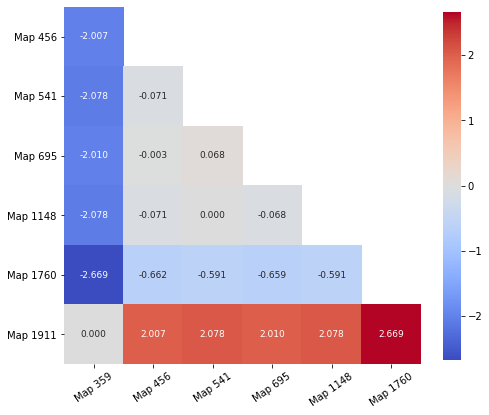

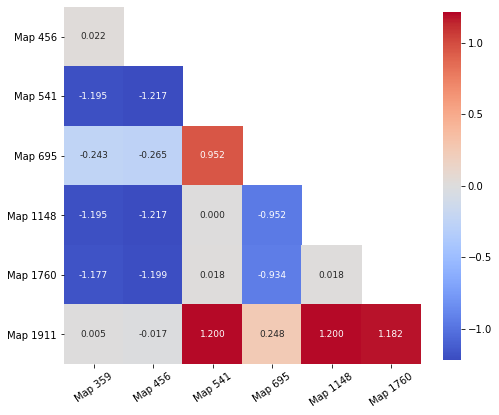

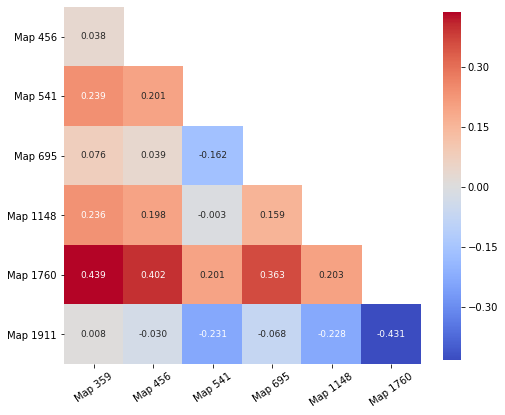

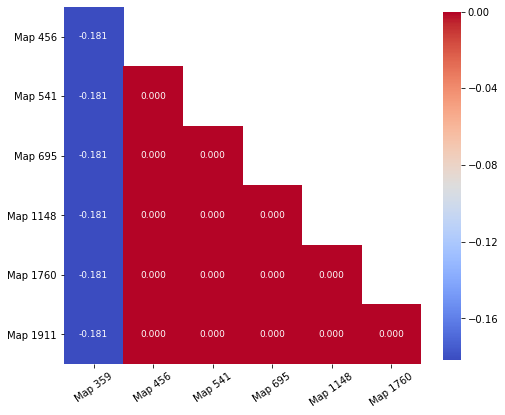

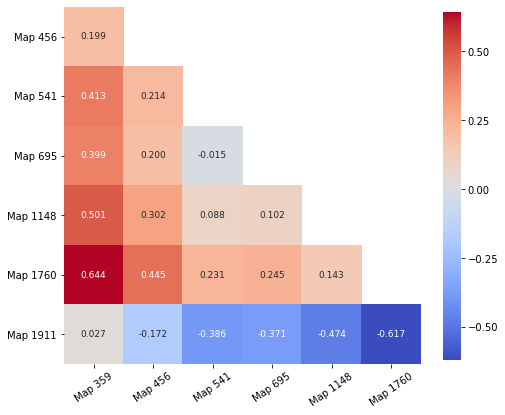

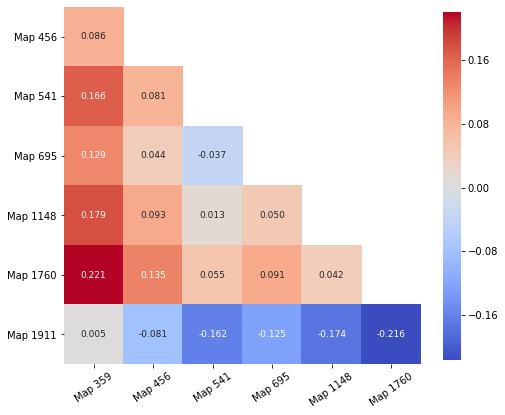

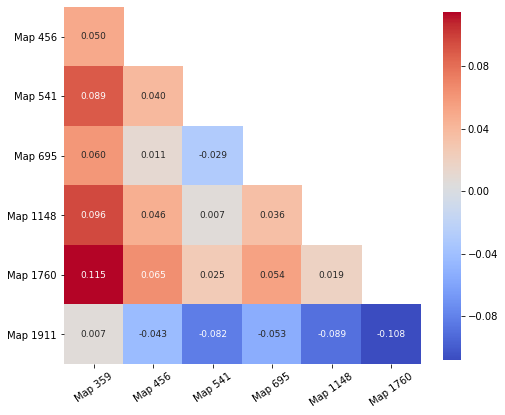

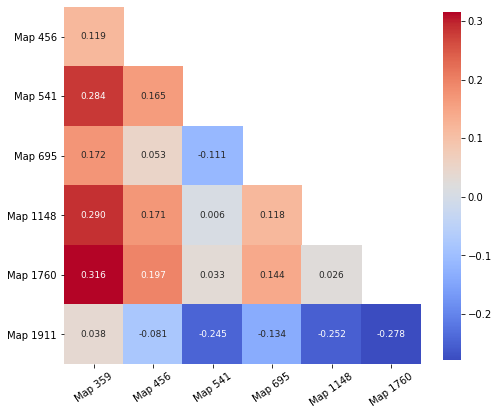

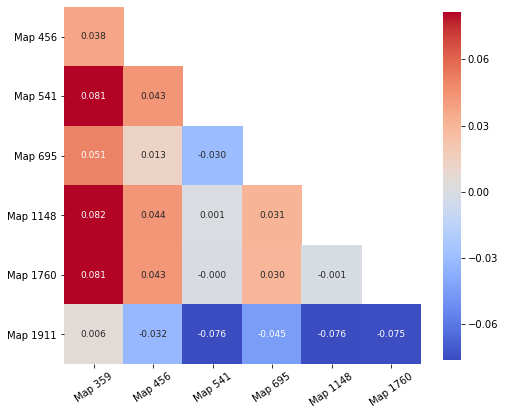

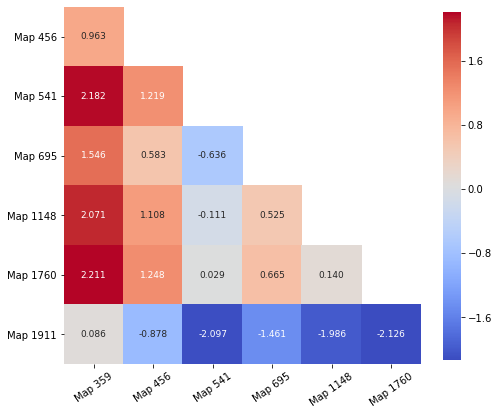

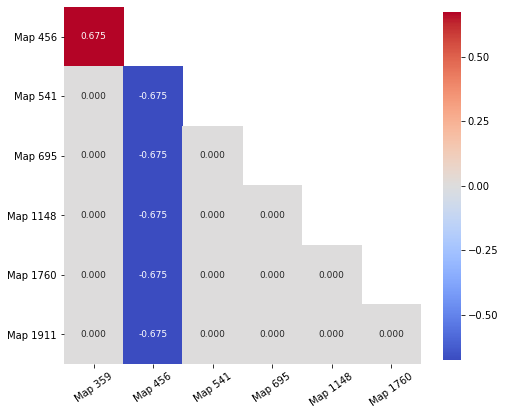

In [96]:
# Store all categories for analysis
cats = list(df.columns)
#Create heatmaps for all kappa categories and save to disk
for i in range(len(cats)):
    process_cat(df, cats[i], 'Kappa', kappa_maps, cats)

# Overall Accuracy

In [48]:
# Create CM showing quantity disagreement for oa representative maps
oa_data = []
oa_row_name = []
oa_maps = ['map10', 'map359', 'map456', 'map541', 'map695', 'map696', 'map1911']
iterator = its.product(oa_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    oa_data.append(dat)
    oa_row_name.append(row)

df2 = pd.DataFrame(data=oa_data, index=oa_row_name)
df2 = df2.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df2 = df2.loc[:, (df2 != 0).any(axis=0)]

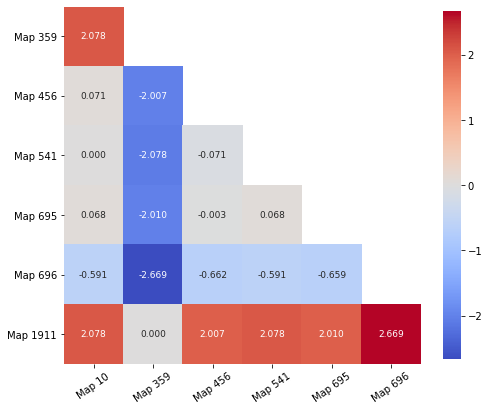

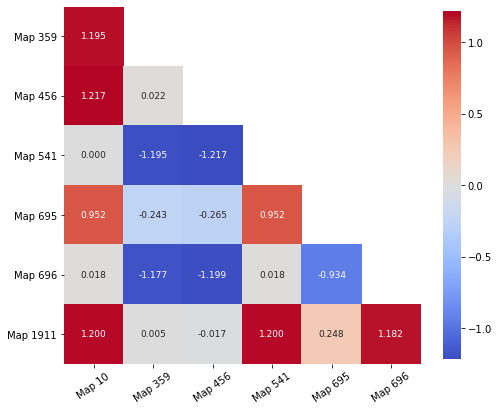

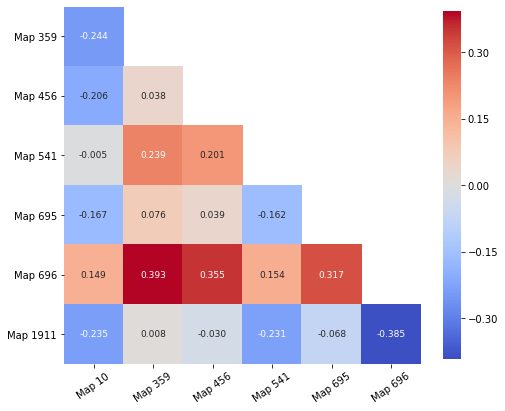

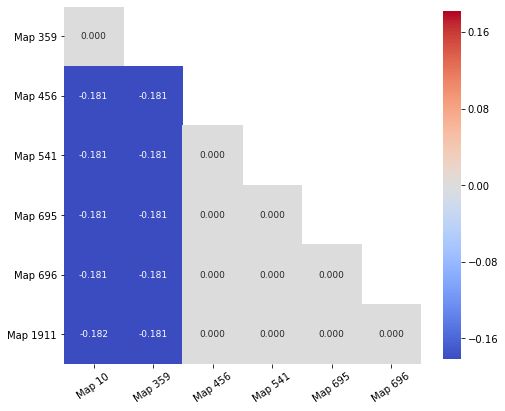

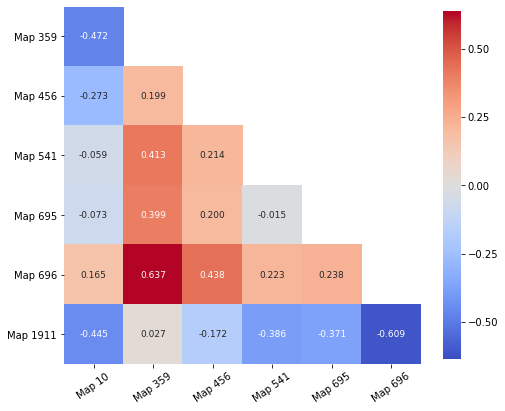

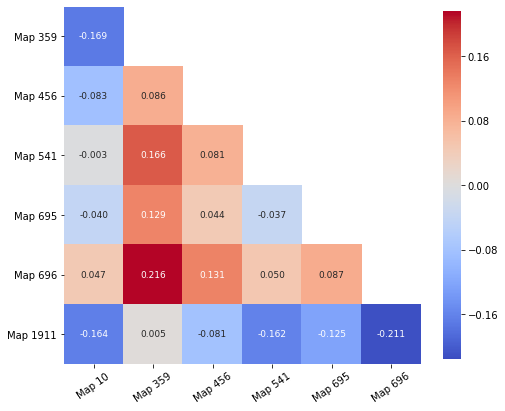

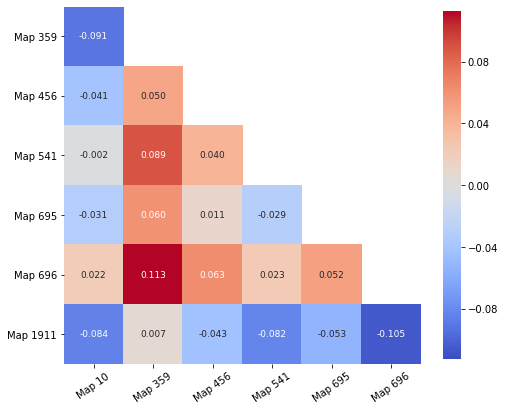

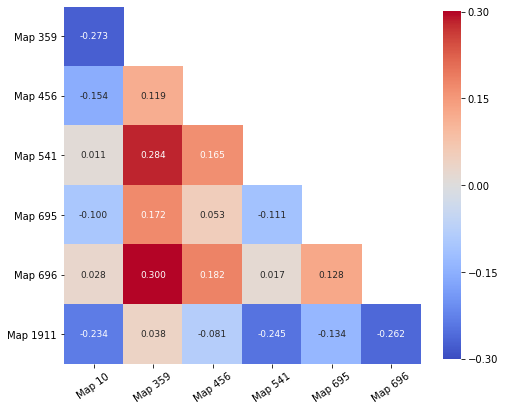

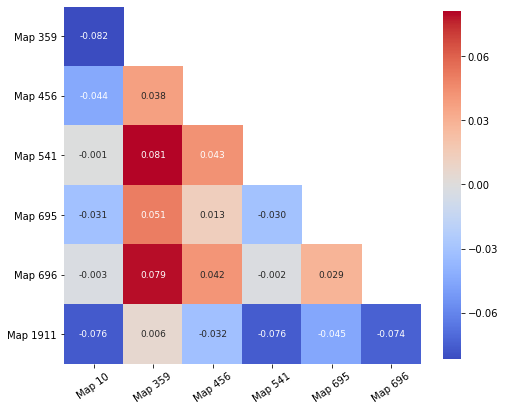

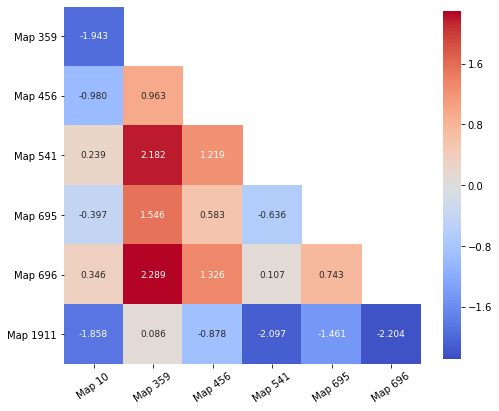

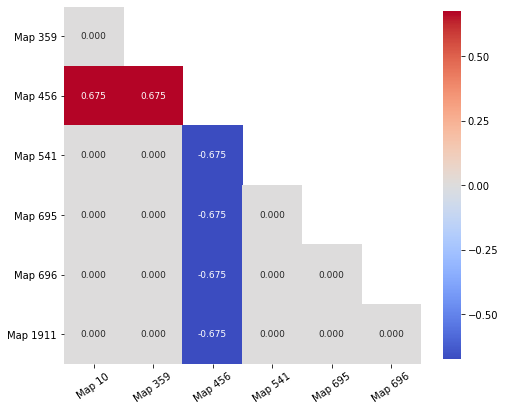

In [97]:
# Store all categories for analysis
cats2 = list(df2.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats2)):
    process_cat(df2, cats2[i], 'OA', oa_maps, cats2)

# Shannon's 

In [78]:
# Create CM showing quantity disagreement for shannon's representative maps
shan_data = []
shan_row_name = []
shan_maps = ['map61', 'map1248', 'map1454', 'map1457']
iterator = its.product(shan_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    shan_data.append(dat)
    shan_row_name.append(row)

df3 = pd.DataFrame(data=shan_data, index=shan_row_name)
df3 = df3.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df3 = df3.loc[:, (df3 != 0).any(axis=0)]

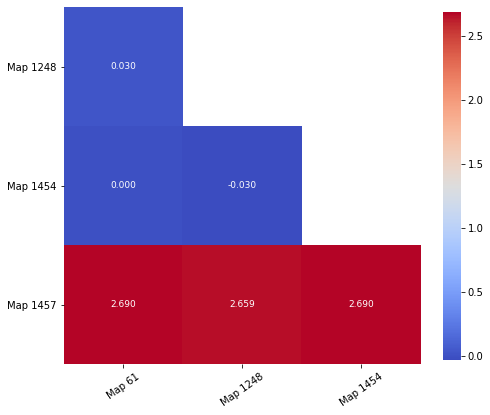

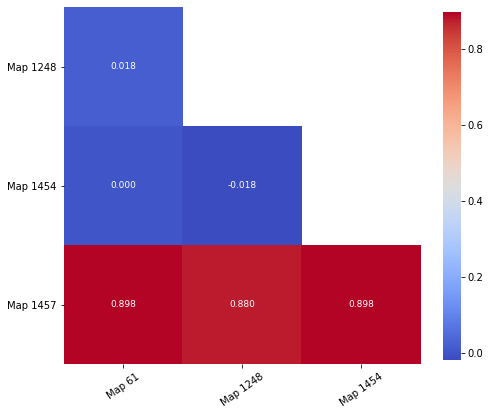

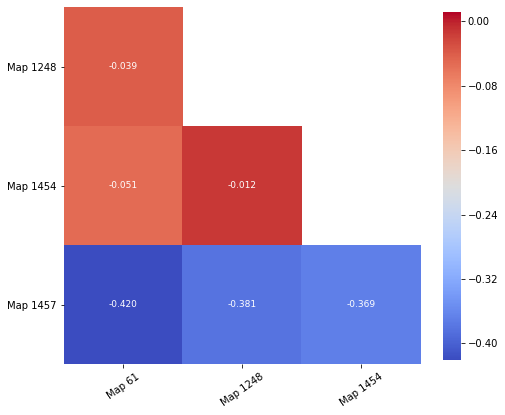

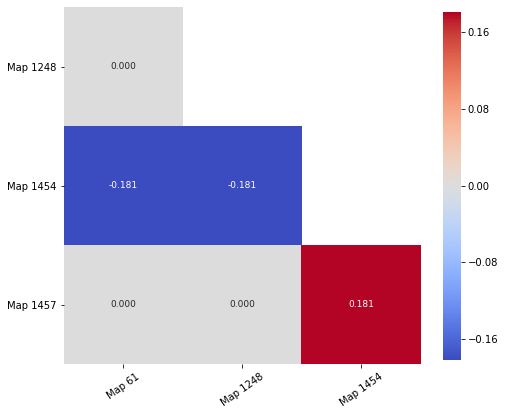

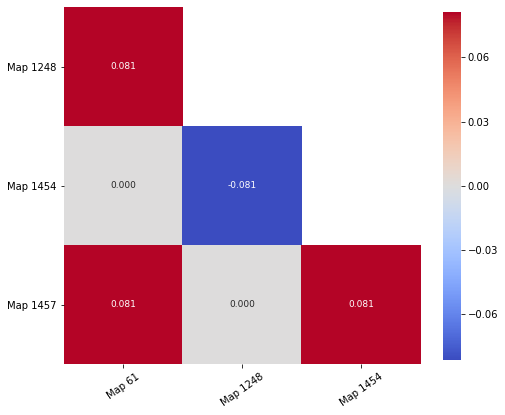

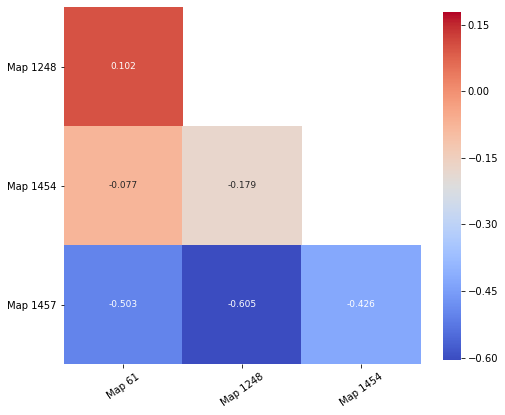

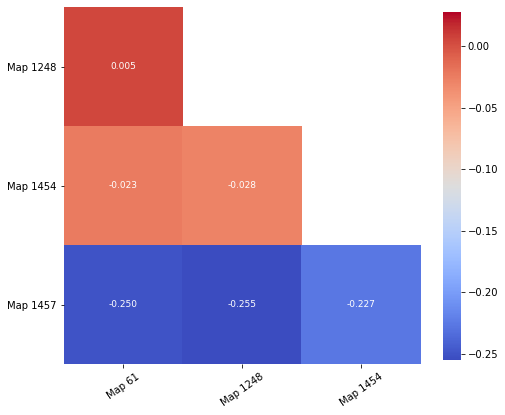

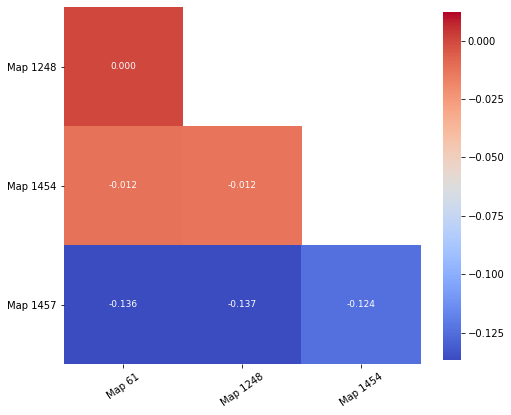

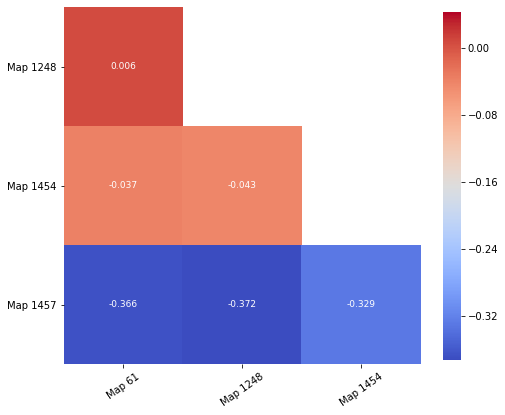

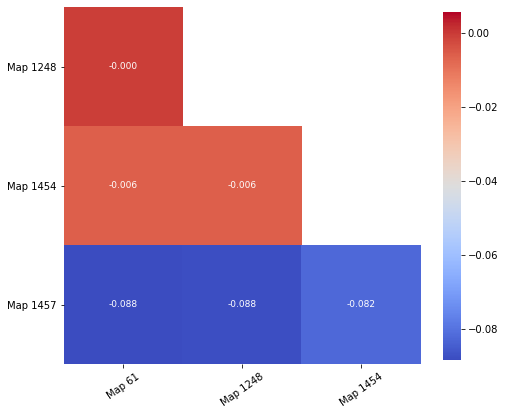

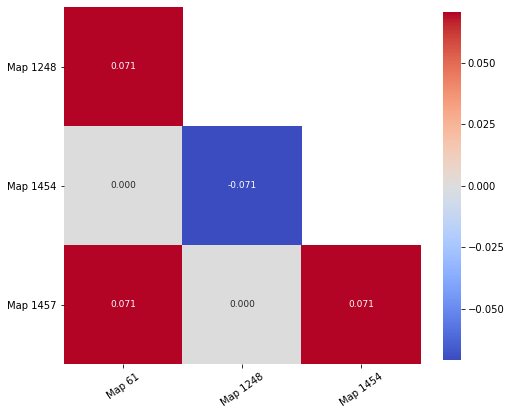

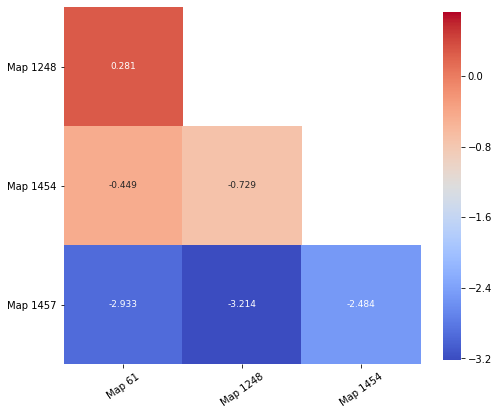

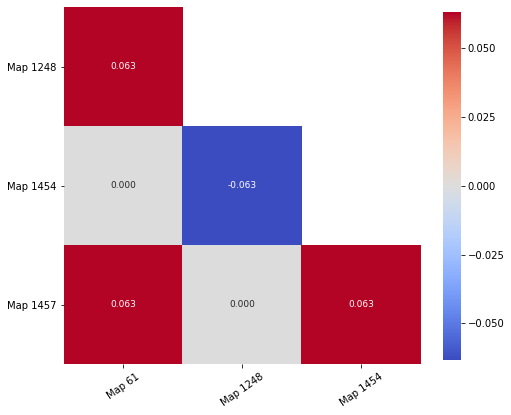

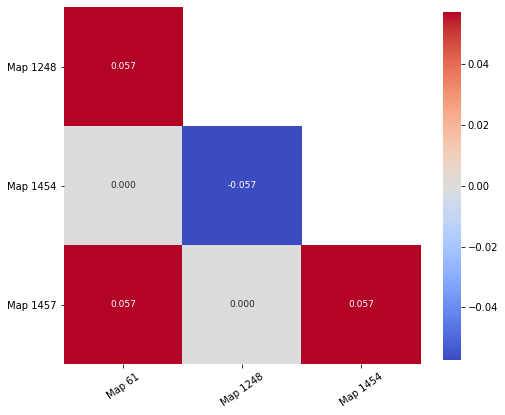

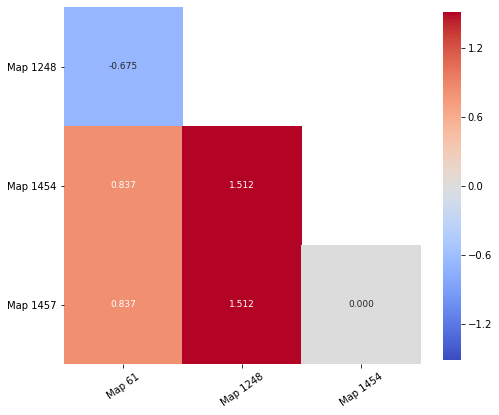

In [98]:
# Store all categories for analysis
cats3 = list(df3.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats3)):
    process_cat(df3, cats3[i], 'Shannon', shan_maps, cats3)

# Simpson's 

In [79]:
# Create CM showing quantity disagreement for simpson's representative maps
simp_data = []
simp_row_name = []
simp_maps = ['map65', 'map857', 'map1448', 'map1784', 'map1830']
iterator = its.product(simp_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    simp_data.append(dat)
    simp_row_name.append(row)
    
df4 = pd.DataFrame(data=simp_data, index=simp_row_name)
df4 = df4.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df4 = df4.loc[:, (df4 != 0).any(axis=0)]

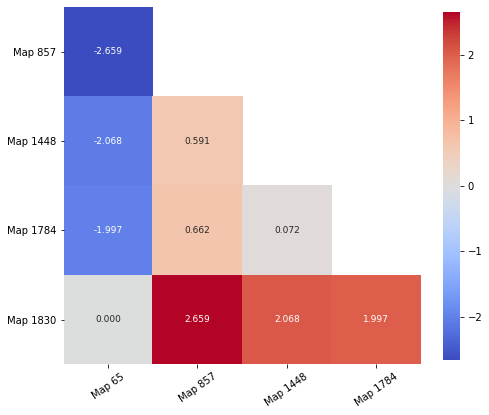

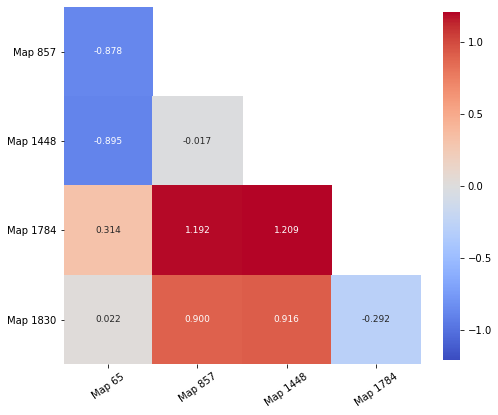

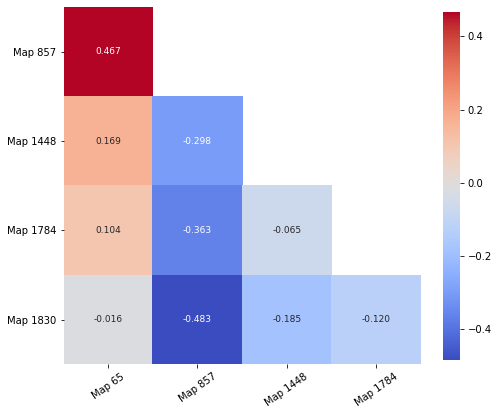

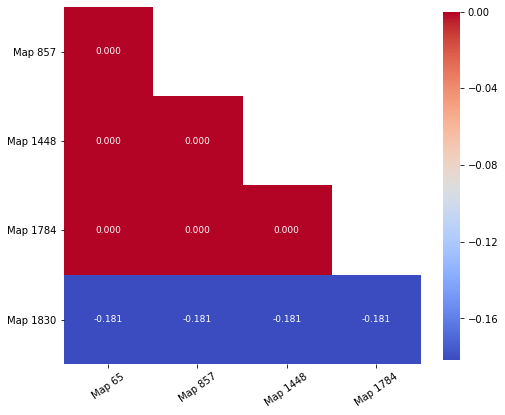

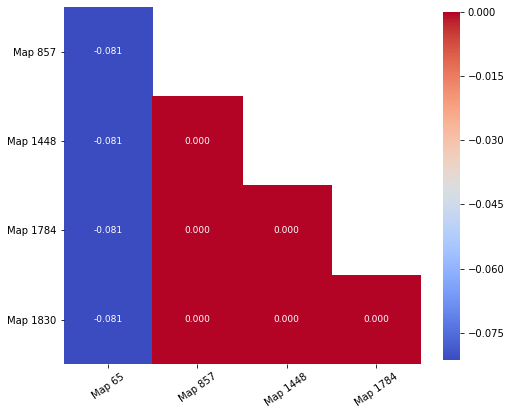

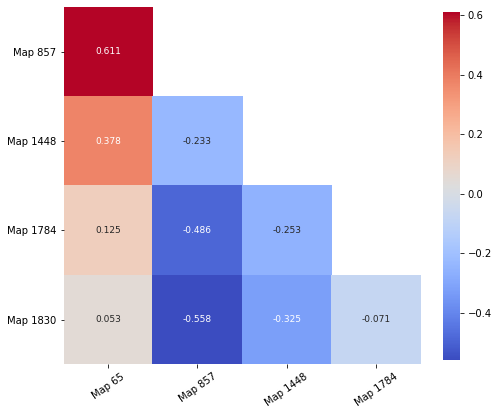

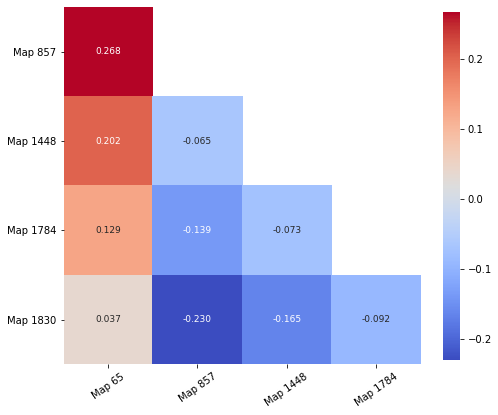

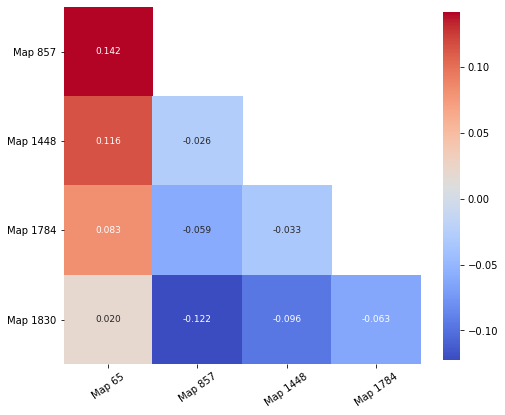

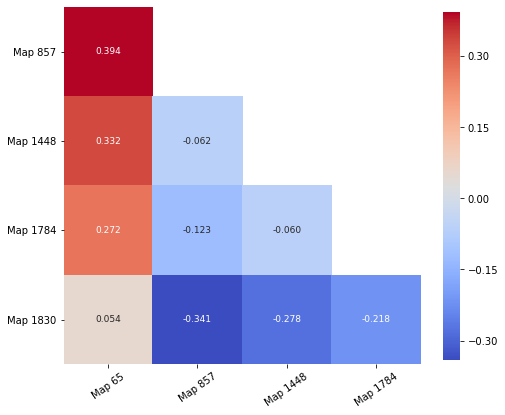

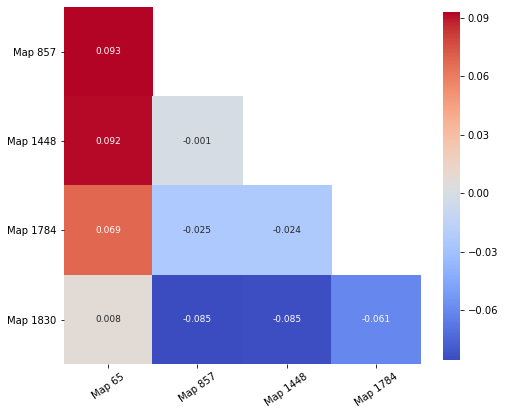

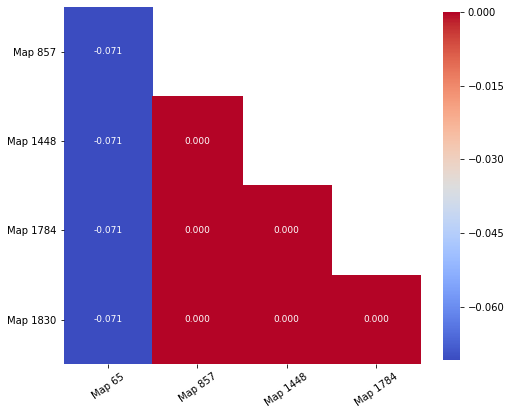

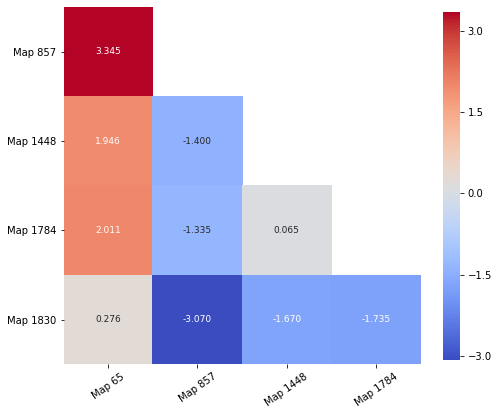

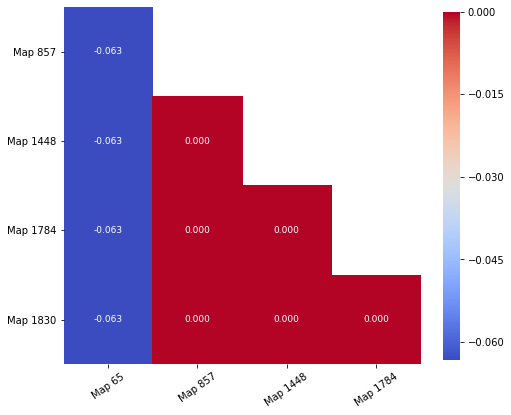

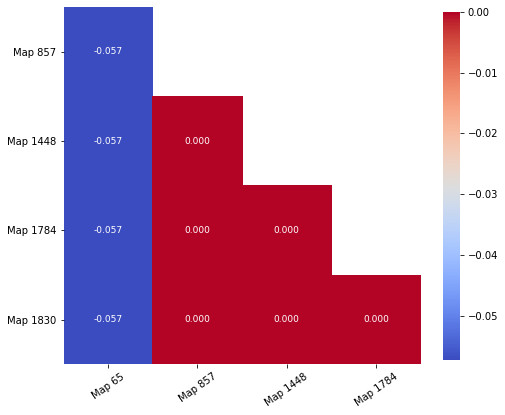

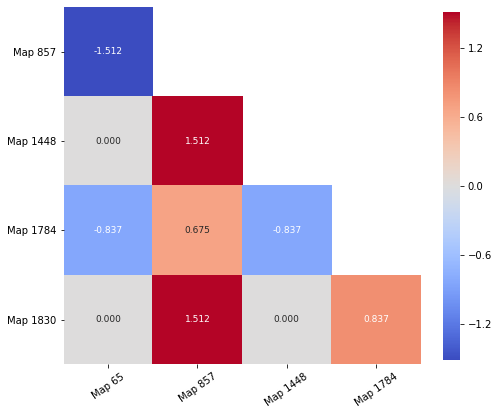

In [99]:
# Store all categories for analysis
cats4 = list(df4.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats4)):
    process_cat(df4, cats4[i], 'Simp', simp_maps, cats4)

# Overall Allocation Difference

In [80]:
# Create CM showing quantity disagreement for oad representative maps
oad_data = []
oad_row_name = []
oad_maps = ['map263', 'map453', 'map678', 'map1760', 'map1852', 'map1918']
iterator = its.product(oad_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    oad_data.append(dat)
    oad_row_name.append(row)
    
df5 = pd.DataFrame(data=oad_data, index=oad_row_name)
df5 = df5.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df5 = df5.loc[:, (df5 != 0).any(axis=0)]

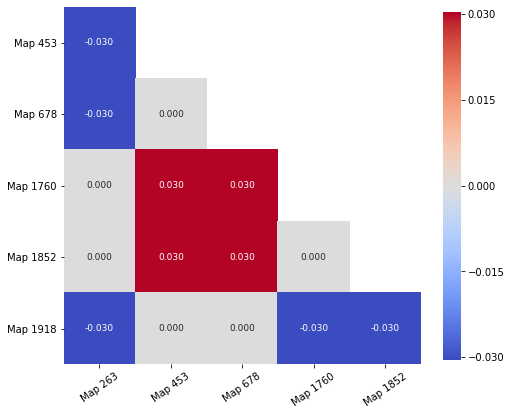

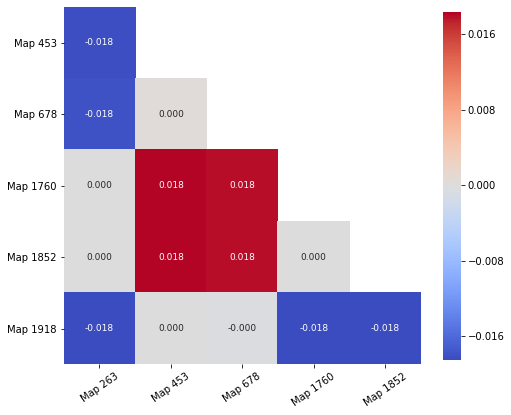

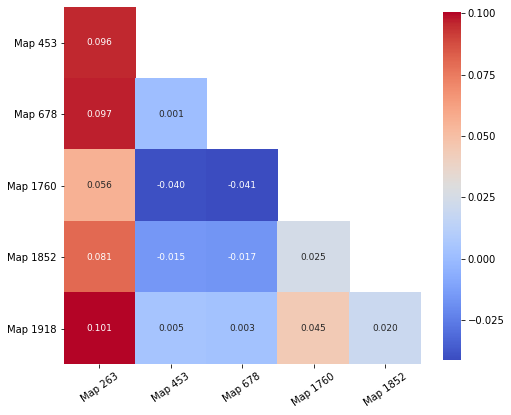

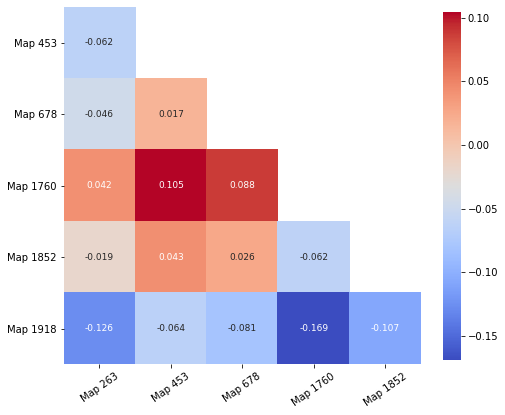

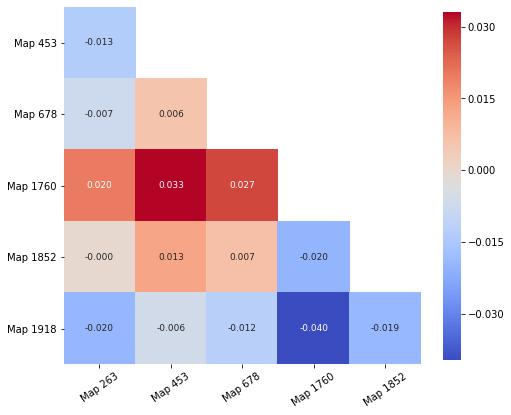

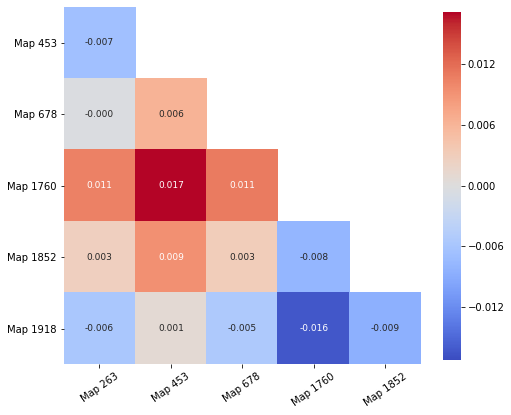

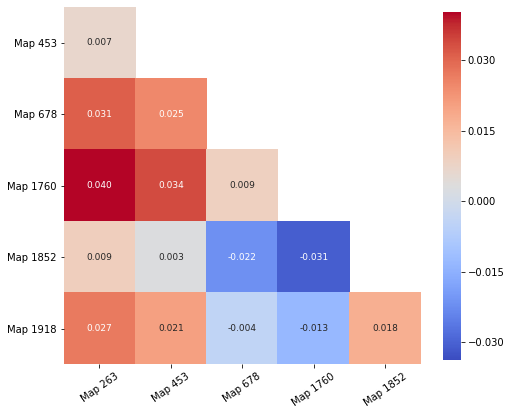

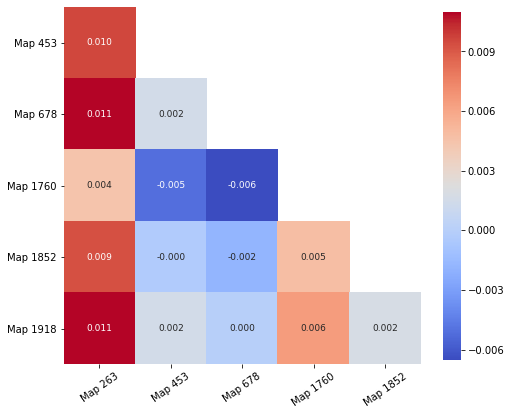

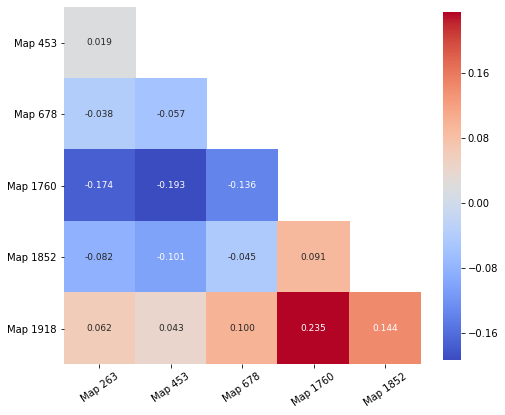

In [101]:
# Store all categories for analysis
cats5 = list(df5.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats5)):
    process_cat(df5, cats5[i], 'TAD', oad_maps, cats5)

# Total Quantity Difference

In [81]:
# Create CM showing quantity disagreement for oqd representative maps
oqd_data = []
oqd_row_name = []
oqd_maps = ['map1057', 'map1472', 'map1833', 'map1978']
iterator = its.product(oqd_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    oqd_data.append(dat)
    oqd_row_name.append(row)
    
df6 = pd.DataFrame(data=oqd_data, index=oqd_row_name)
df6 = df6.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df6 = df6.loc[:, (df6 != 0).any(axis=0)]

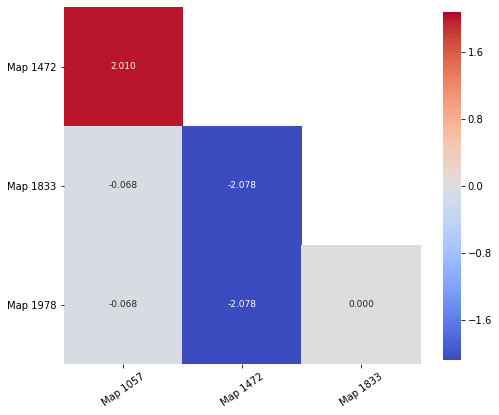

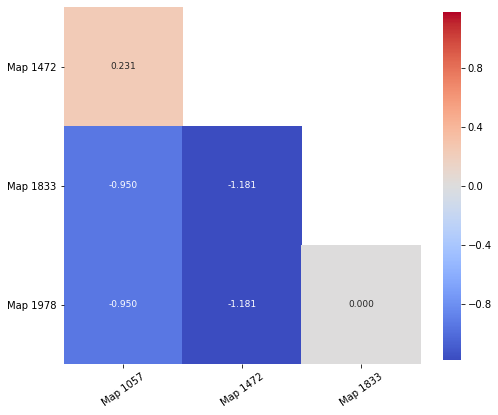

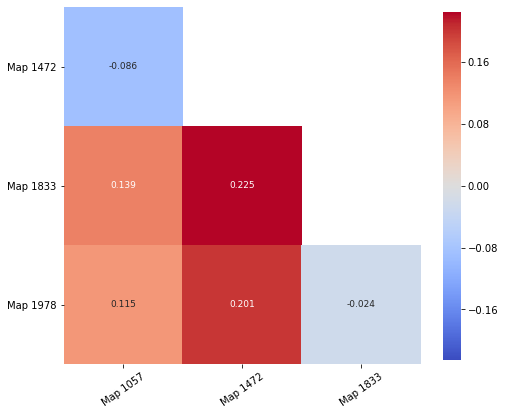

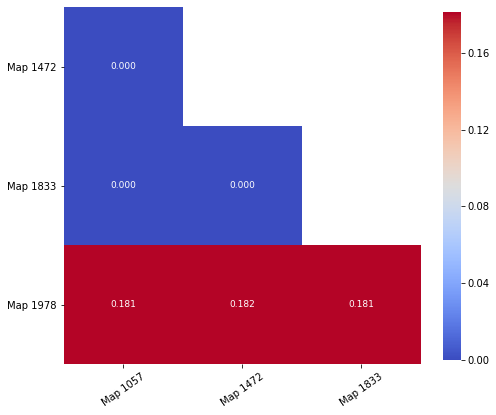

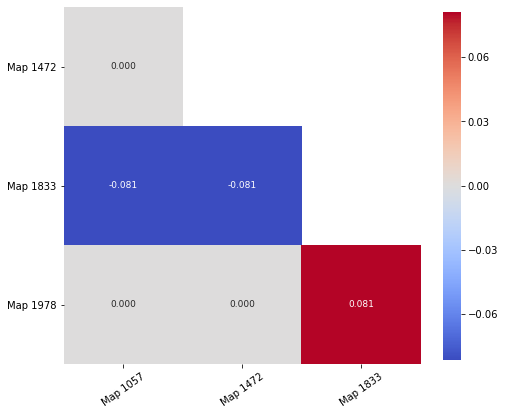

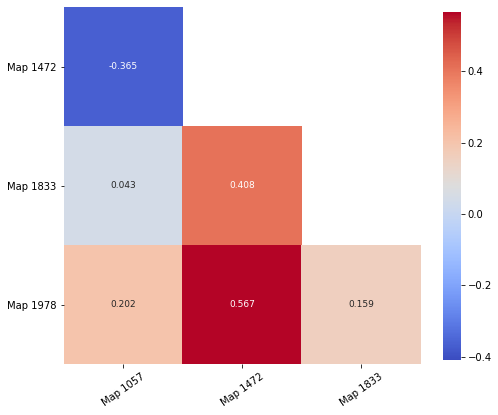

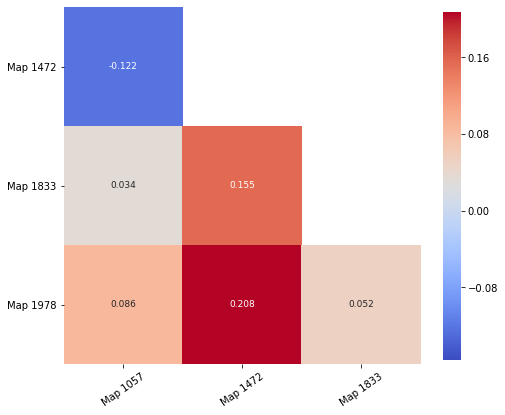

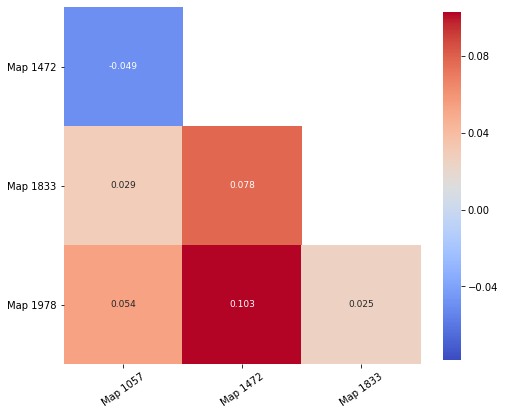

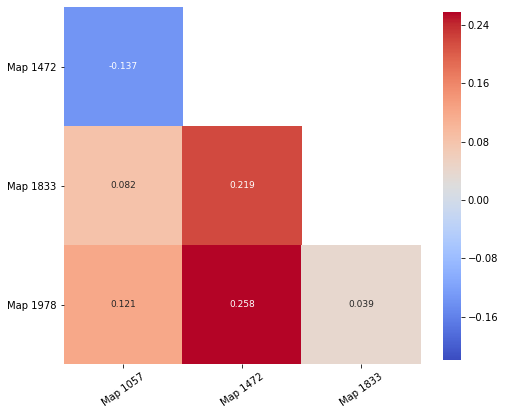

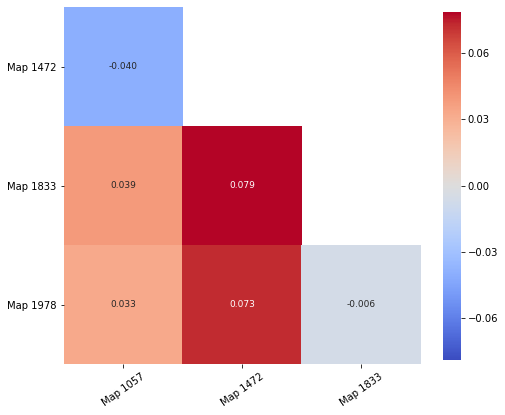

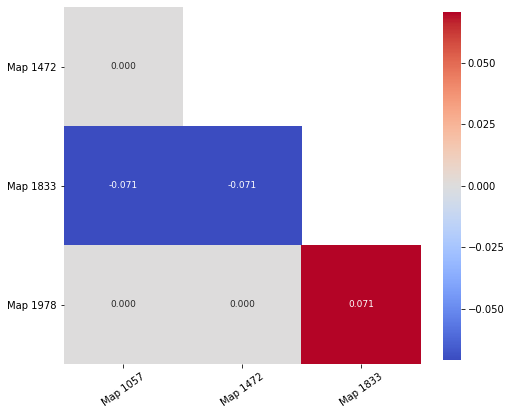

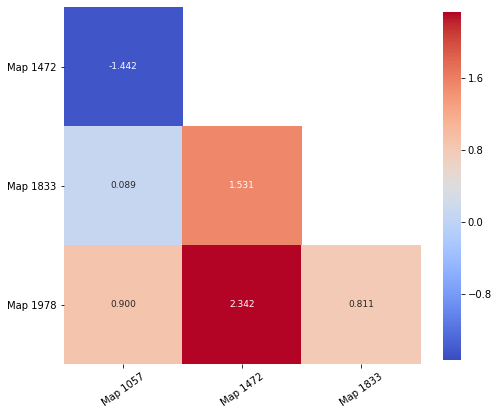

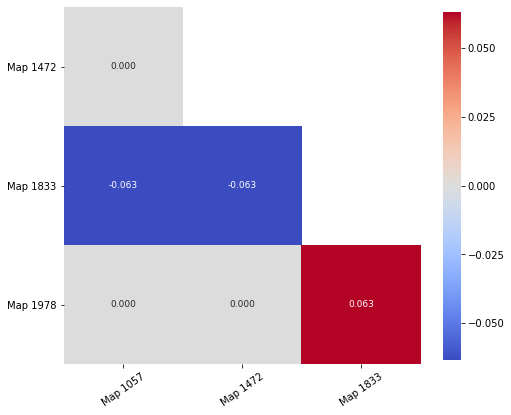

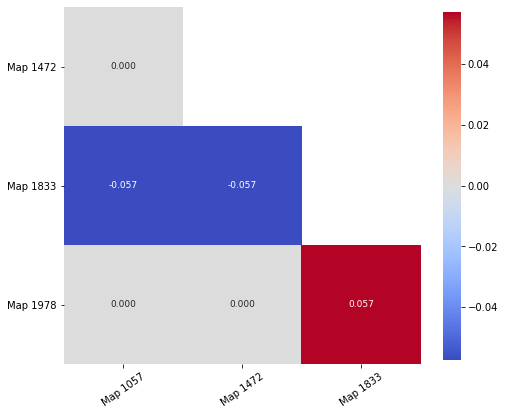

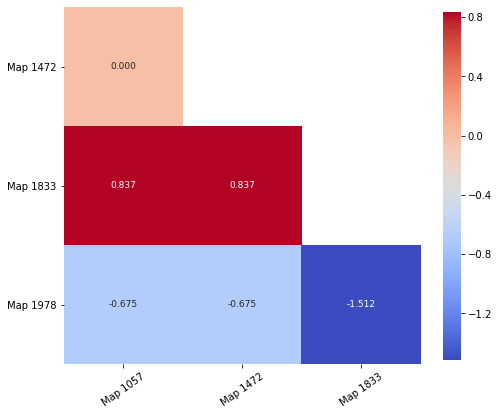

In [102]:
# Store all categories for analysis
cats6 = list(df6.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats6)):
    process_cat(df6, cats6[i], 'TQD', oqd_maps, cats6)

# TCA4

In [82]:
# Create CM showing quantity disagreement for tca4 representative maps
tca4_data = []
tca4_row_name = []
tca4_maps = ['map217', 'map332', 'map604']
iterator = its.product(tca4_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    tca4_data.append(dat)
    tca4_row_name.append(row)
    
df7 = pd.DataFrame(data=tca4_data, index=tca4_row_name)
df7 = df7.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df7 = df7.loc[:, (df7 != 0).any(axis=0)]

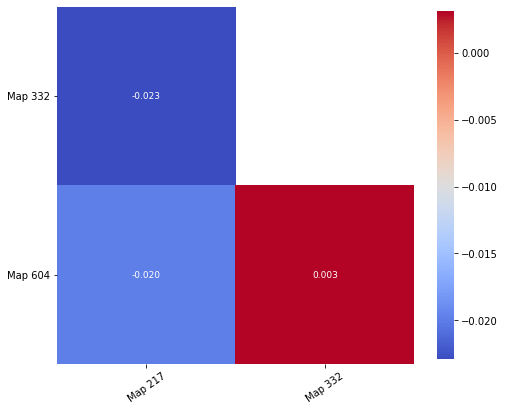

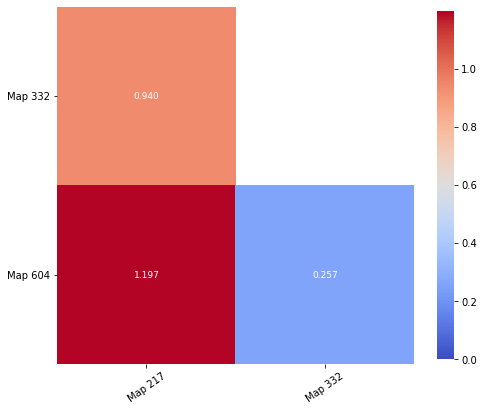

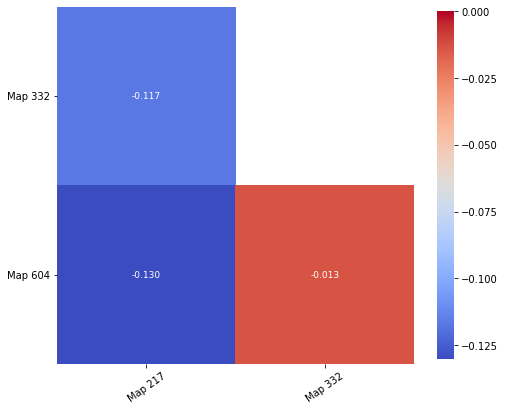

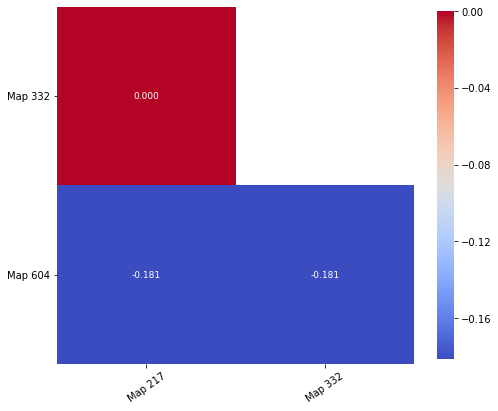

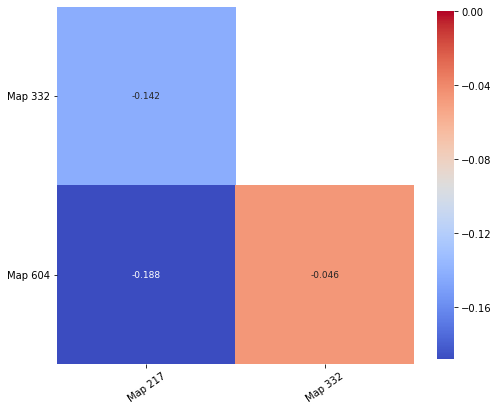

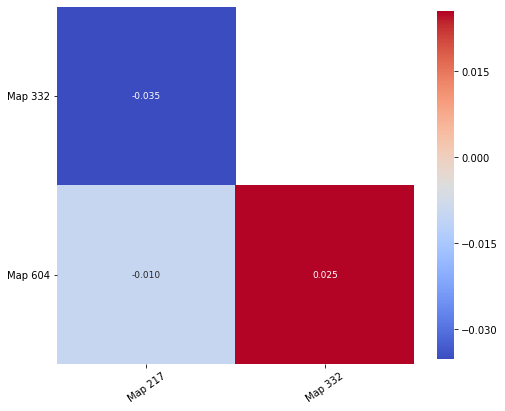

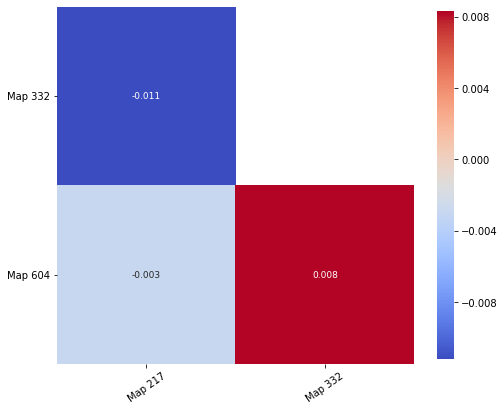

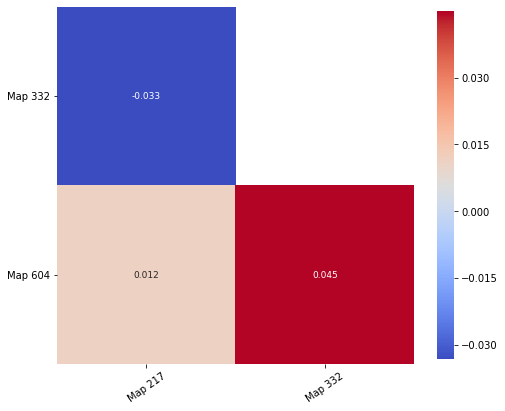

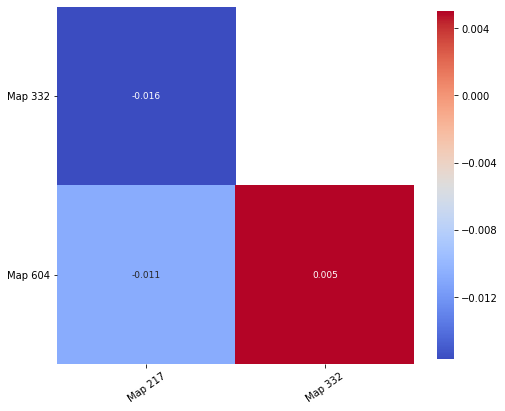

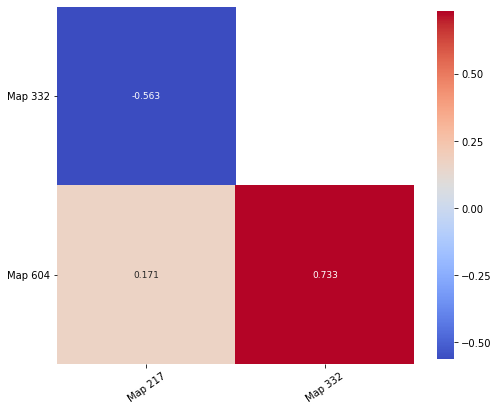

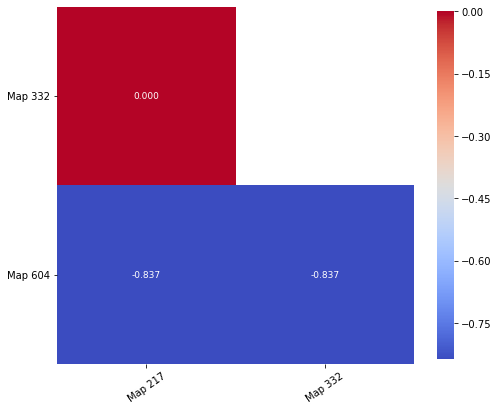

In [103]:
# Store all categories for analysis
cats7 = list(df7.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats7)):
    process_cat(df7, cats7[i], 'tca4', tca4_maps, cats7)

# PLAND4

In [83]:
# Create CM showing quantity disagreement for tca4 representative maps
pland4_data = []
pland4_row_name = []
pland4_maps = ['map264', 'map1422', 'map1877']
iterator = its.product(pland4_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    pland4_data.append(dat)
    pland4_row_name.append(row)
    
df8 = pd.DataFrame(data=pland4_data, index=pland4_row_name)
df8 = df8.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df8 = df8.loc[:, (df8 != 0).any(axis=0)]

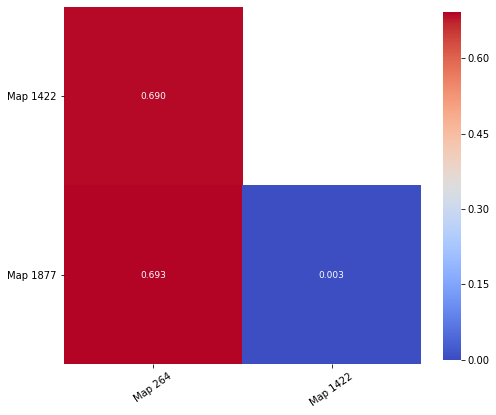

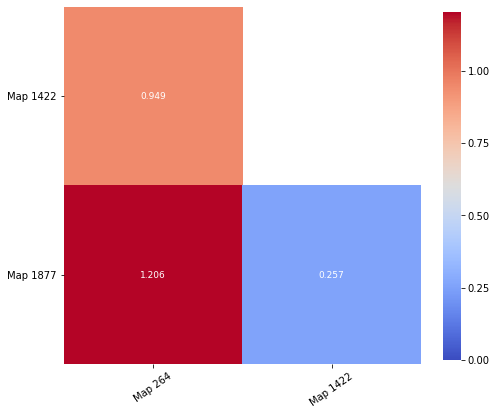

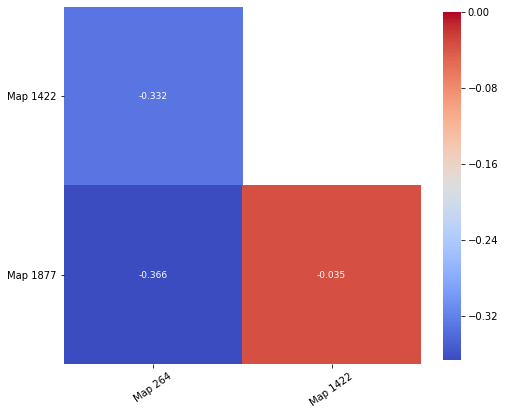

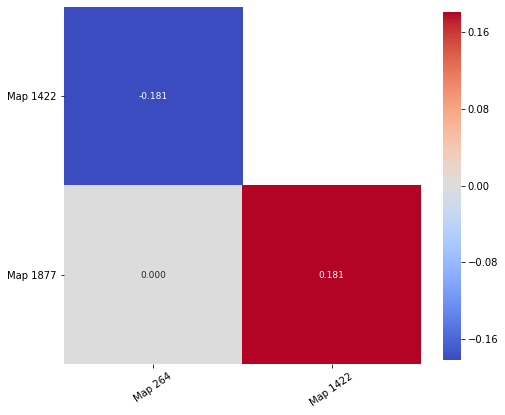

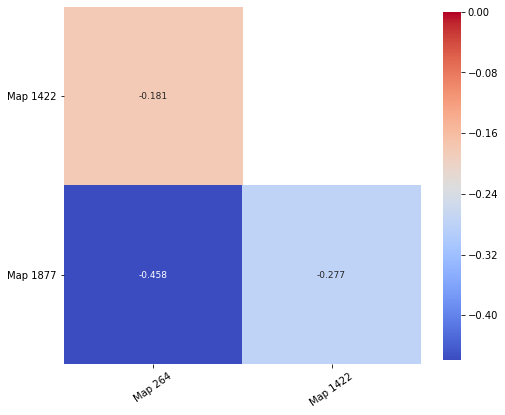

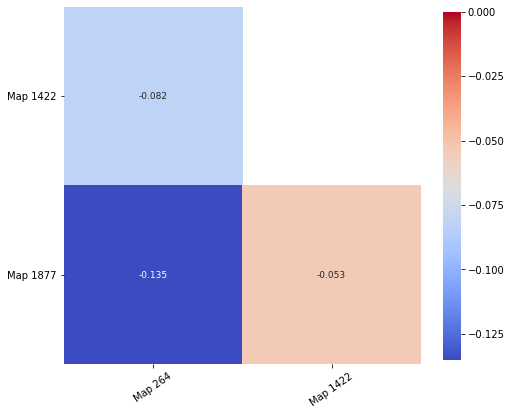

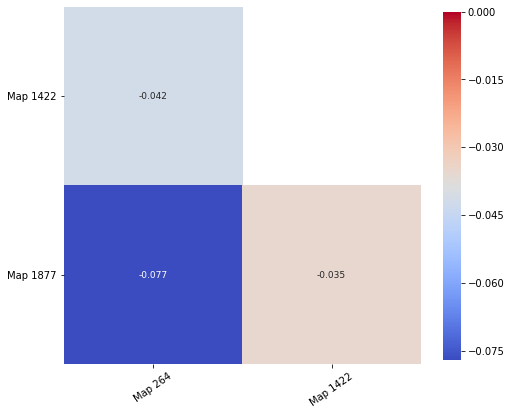

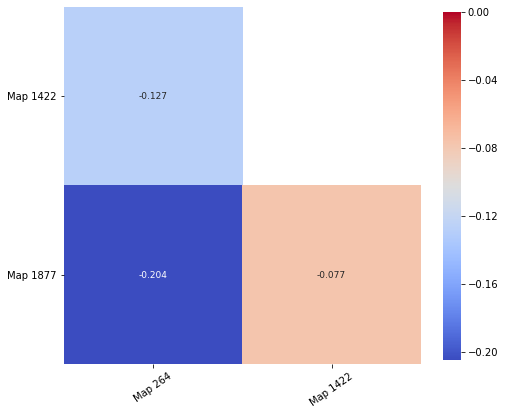

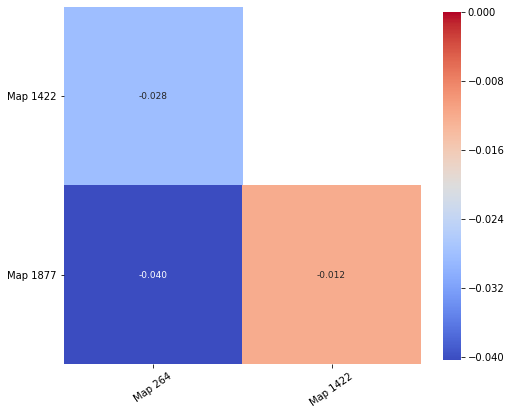

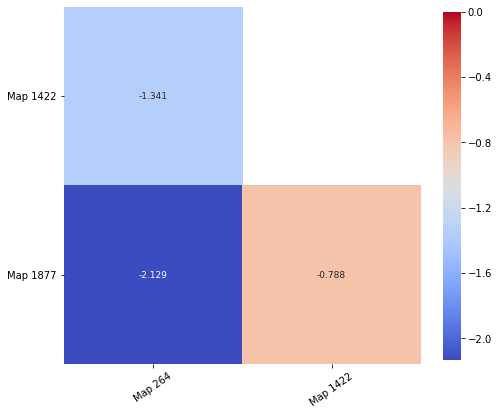

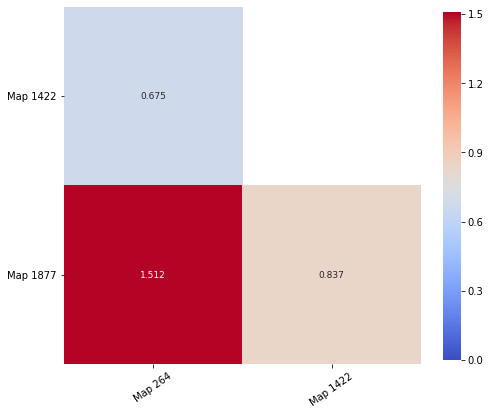

In [104]:
# Store all categories for analysis
cats8 = list(df8.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats8)):
    process_cat(df8, cats8[i], 'PLAND4', pland4_maps, cats8)

# TCA14

In [84]:
# Create CM showing quantity disagreement for tca4 representative maps
tca14_data = []
tca14_row_name = []
tca14_maps = ['map246', 'map296', 'map325', 'map825', 'map1612']
iterator = its.product(tca14_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    tca14_data.append(dat)
    tca14_row_name.append(row)
    
df9 = pd.DataFrame(data=tca14_data, index=tca14_row_name)
df9 = df9.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df9 = df9.loc[:, (df9 != 0).any(axis=0)]

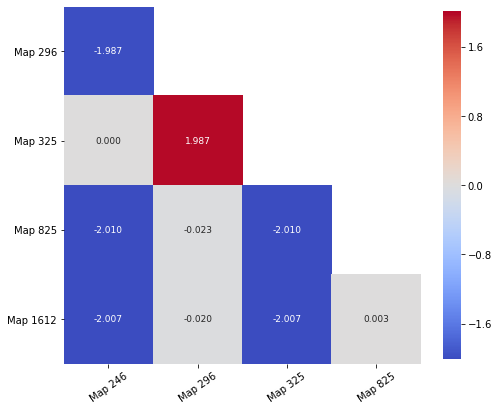

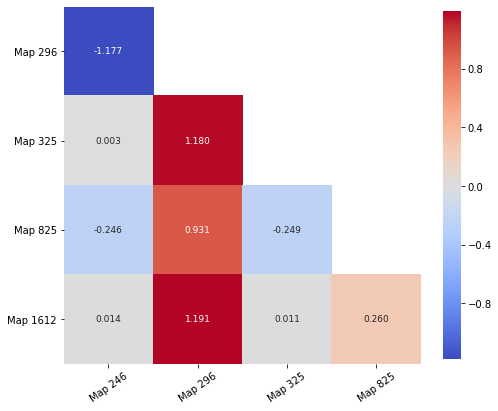

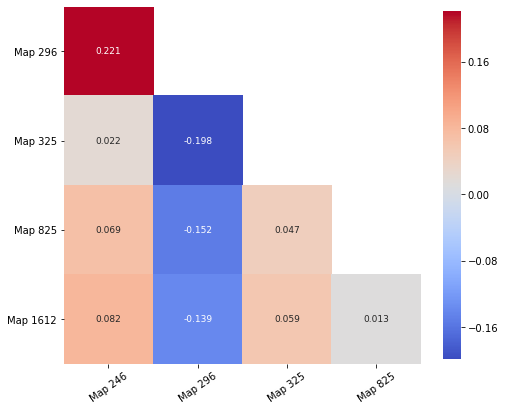

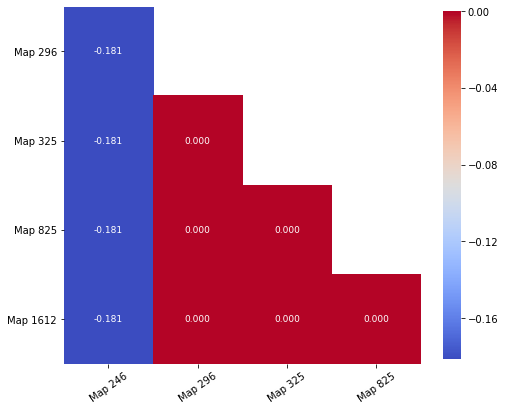

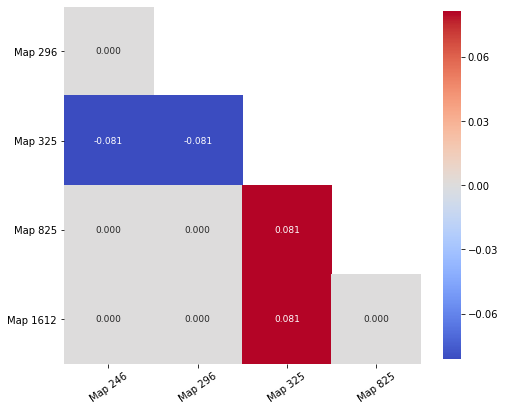

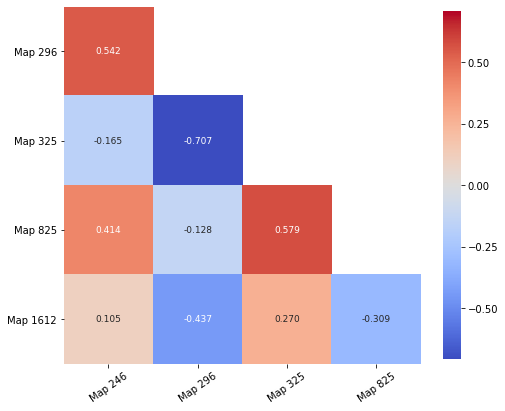

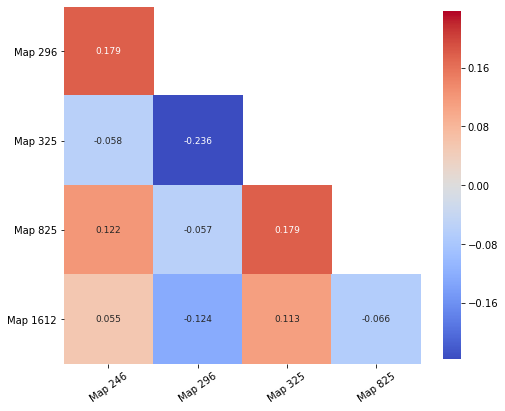

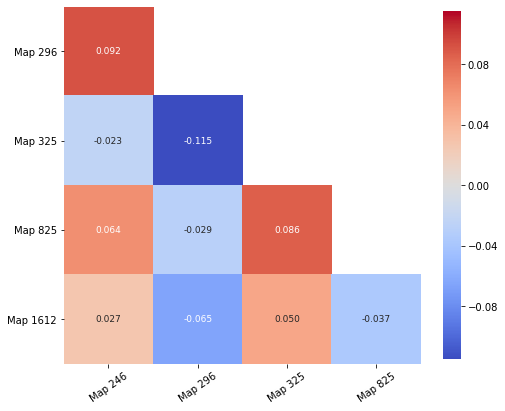

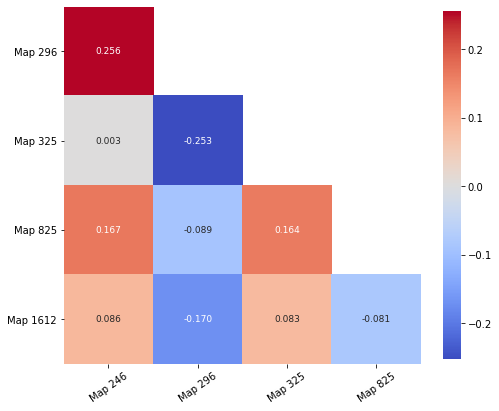

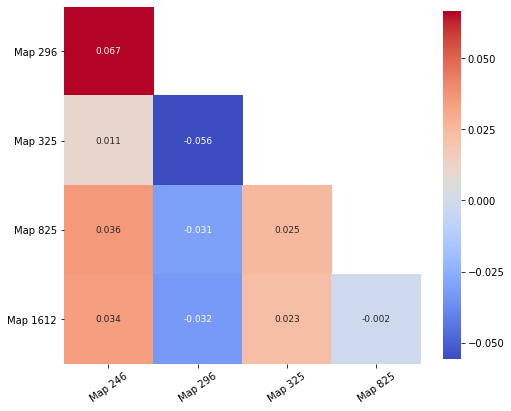

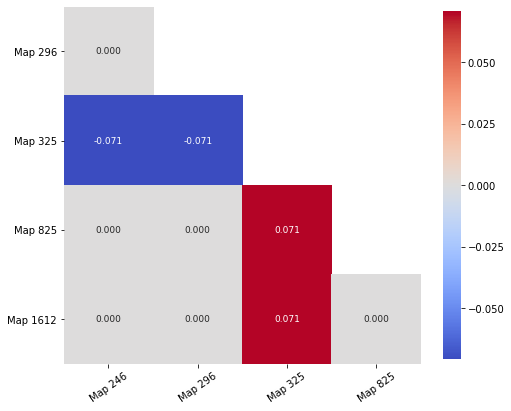

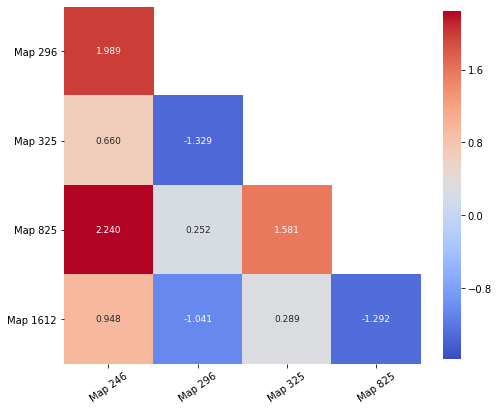

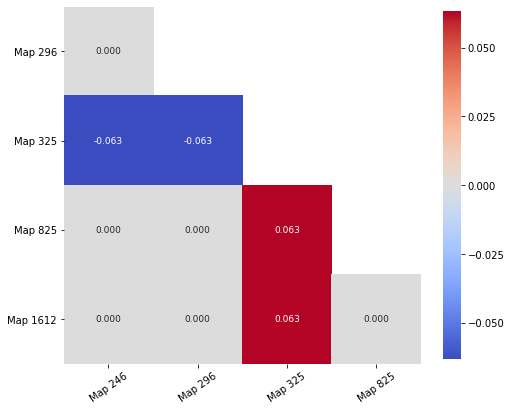

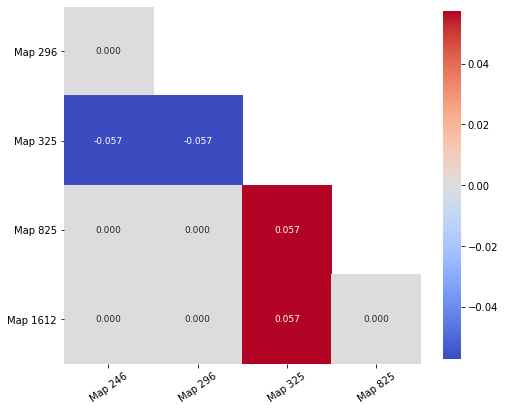

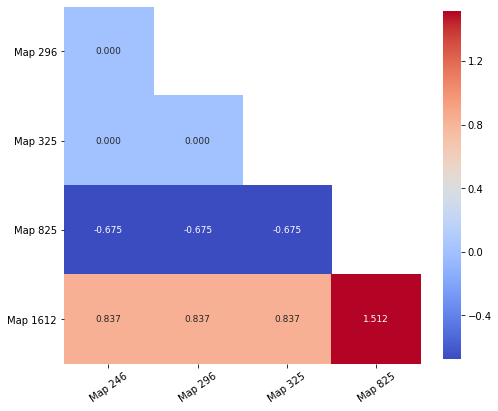

In [106]:
# Store all categories for analysis
cats9 = list(df9.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats9)):
    process_cat(df9, cats9[i], 'TCA14', tca14_maps, cats9)

# PLAND14

In [85]:
# Create CM showing quantity disagreement for tca4 representative maps
pland14_data = []
pland14_row_name = []
pland14_maps = ['map246', 'map325', 'map564', 'map704', 'map843']
iterator = its.product(pland14_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    pland14_data.append(dat)
    pland14_row_name.append(row)
    
df10 = pd.DataFrame(data=pland14_data, index=pland14_row_name)
df10 = df10.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df10 = df10.loc[:, (df10 != 0).any(axis=0)]

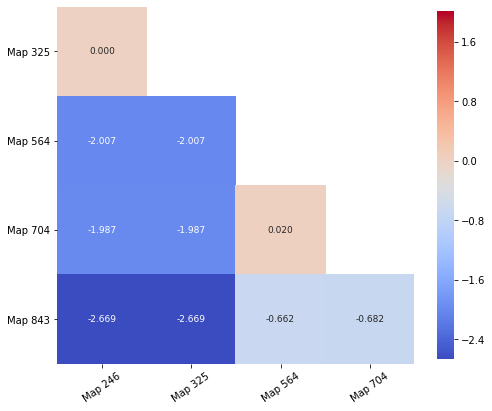

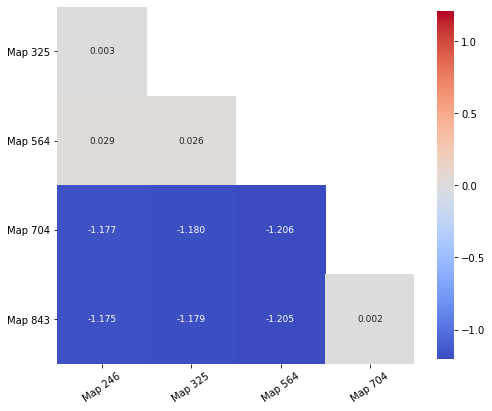

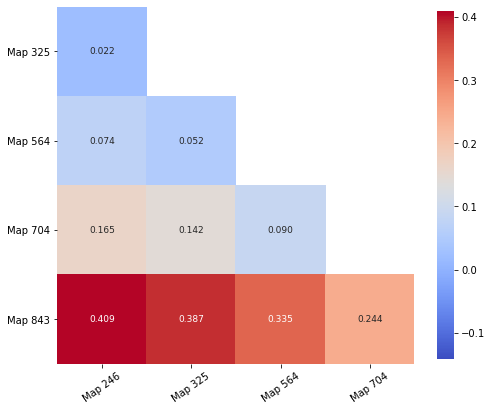

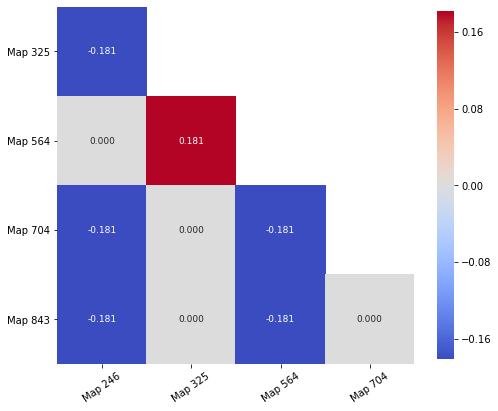

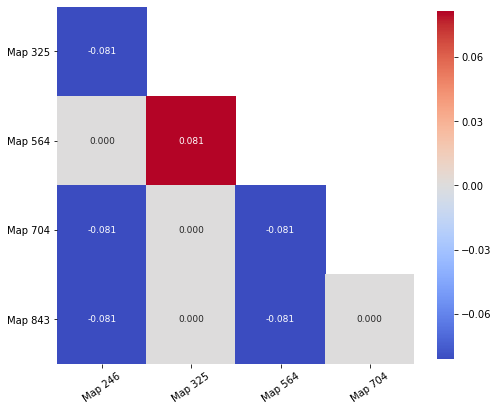

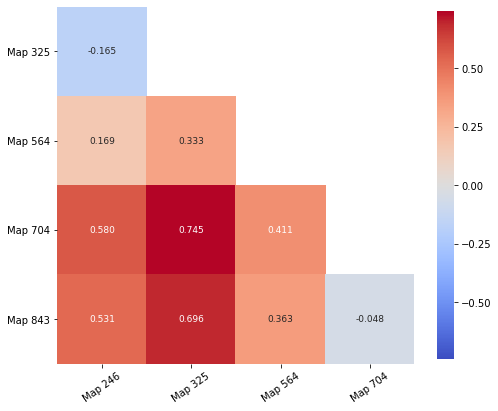

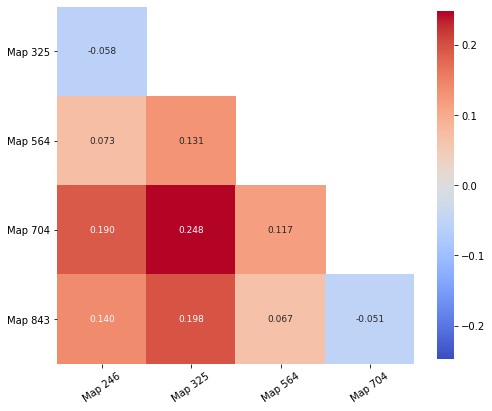

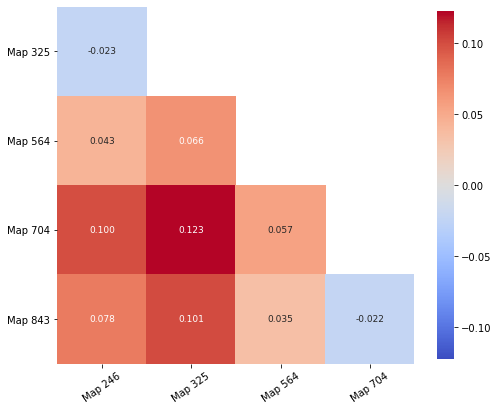

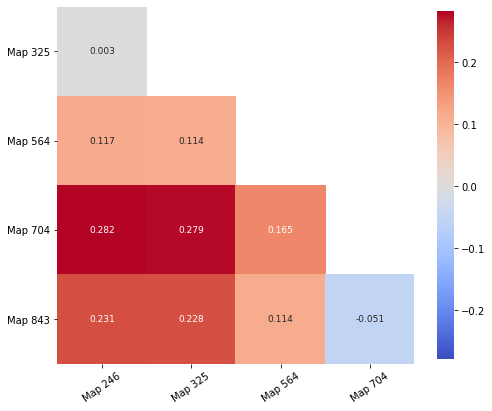

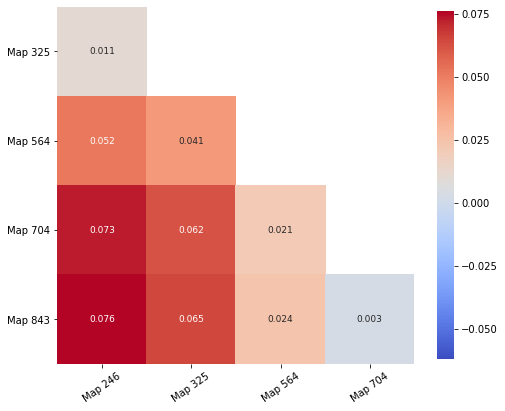

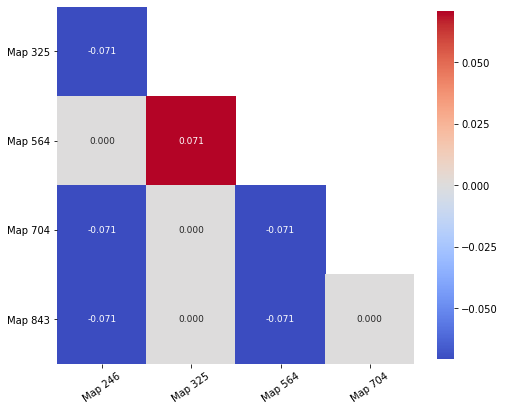

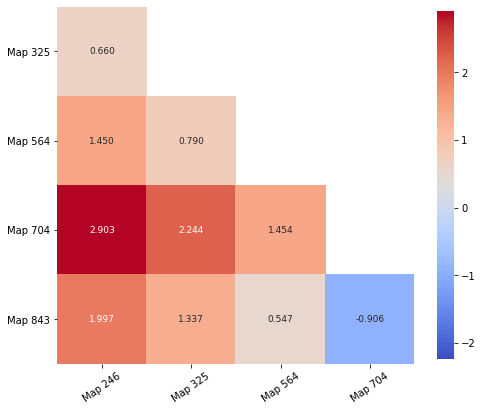

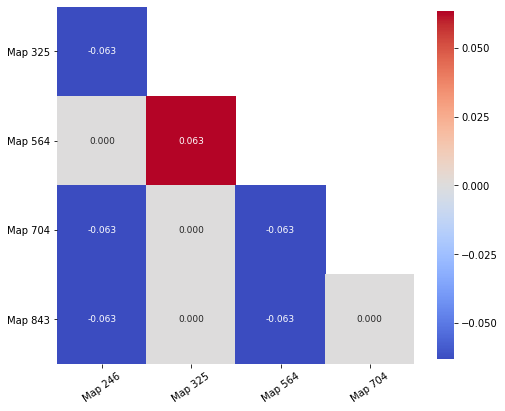

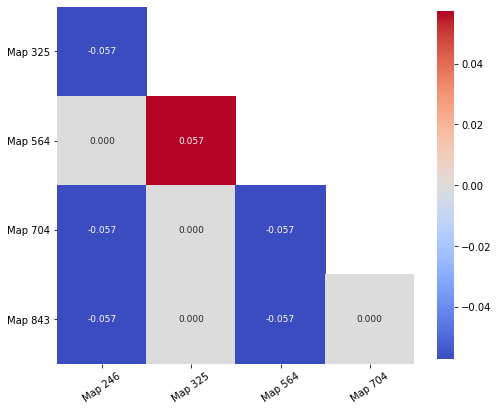

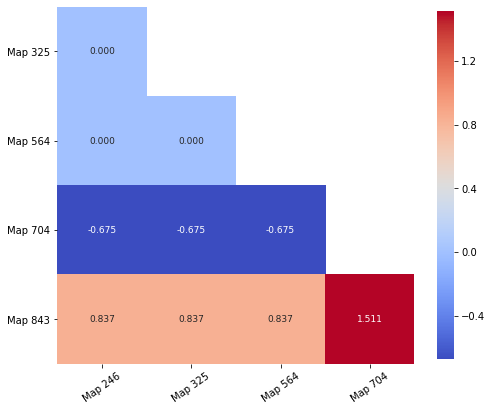

In [107]:
# Store all categories for analysis
cats10 = list(df10.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats10)):
    process_cat(df10, cats10[i], 'PLAND14', pland14_maps, cats10)

# TCA22

In [86]:
# Create CM showing quantity disagreement for tca4 representative maps
# TCA22 and PLAND 22 have the same representative maps so only TCA will be done for both of them
tca22_data = []
tca22_row_name = []
tca22_maps = ['map0', 'map8', 'map35']
iterator = its.product(tca22_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    tca22_data.append(dat)
    tca22_row_name.append(row)
    
df11 = pd.DataFrame(data=tca22_data, index=tca22_row_name)
df11 = df11.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df11 = df11.loc[:, (df11 != 0).any(axis=0)]

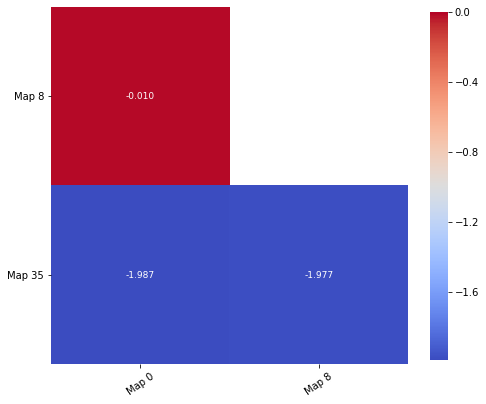

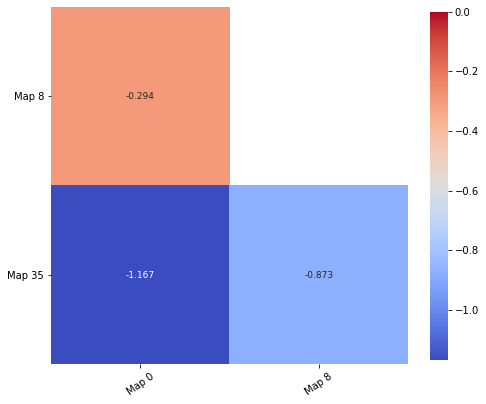

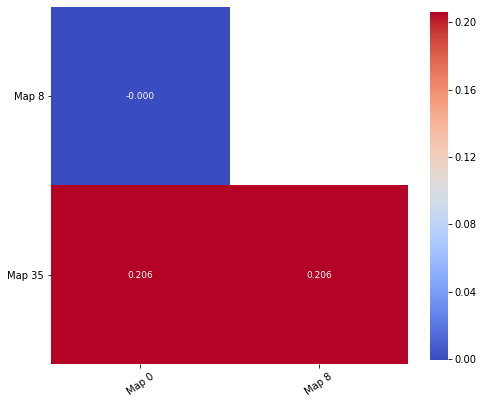

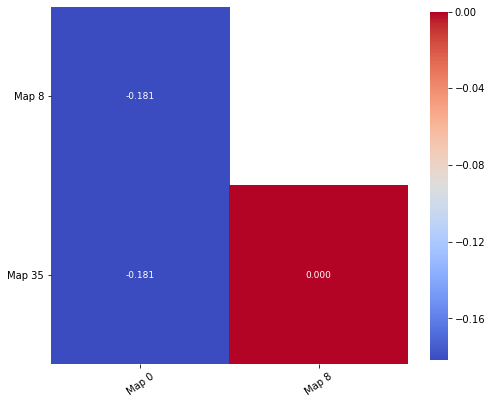

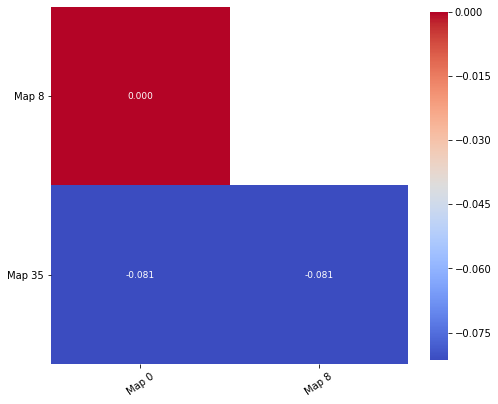

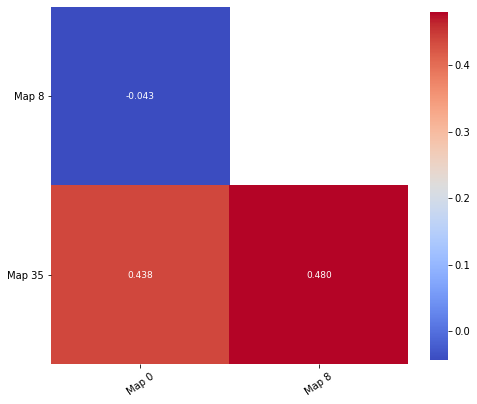

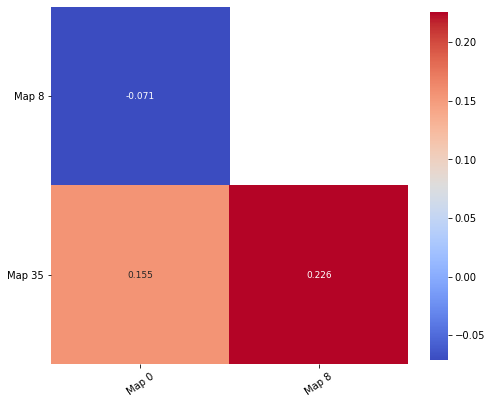

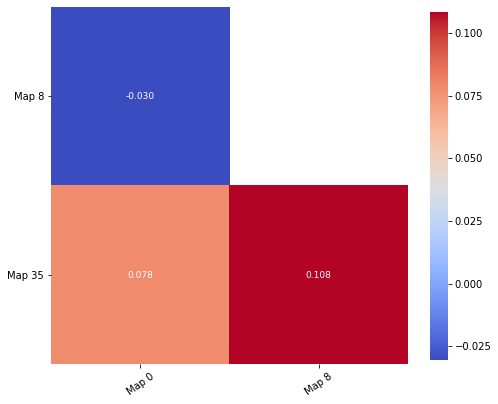

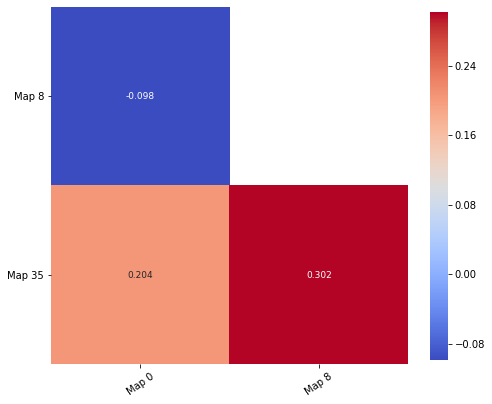

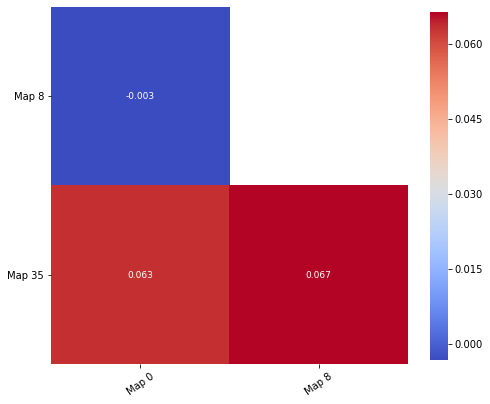

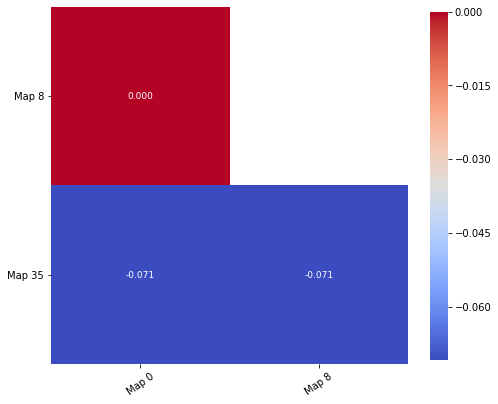

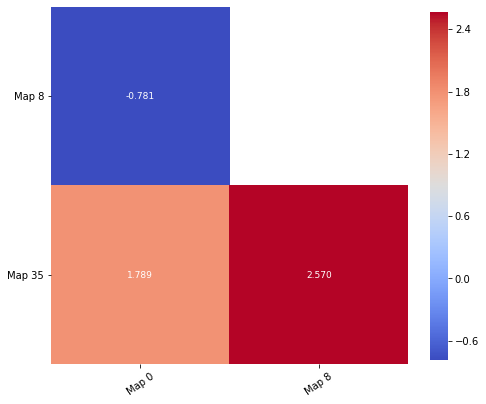

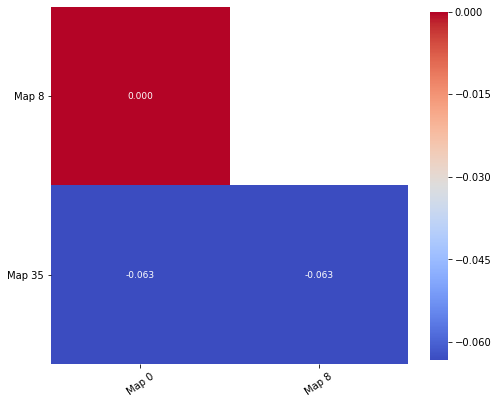

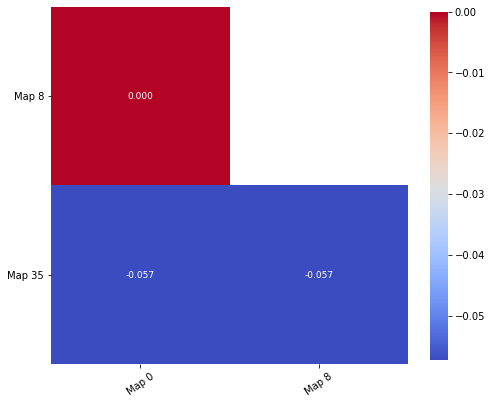

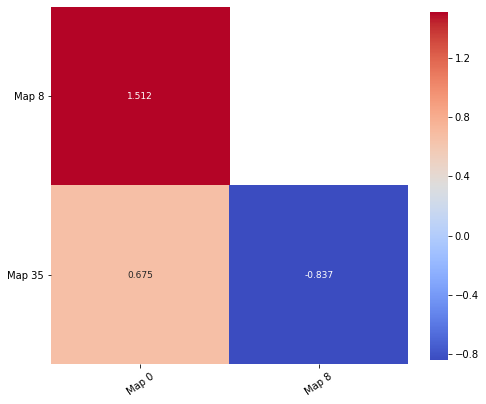

In [108]:
# Store all categories for analysis
cats11 = list(df11.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats11)):
    process_cat(df11, cats11[i], 'TCA22', tca22_maps, cats11)

# QD22

In [87]:
# Create CM showing quantity disagreement for qd22 representative maps
qd22_data = []
qd22_row_name = []
qd22_maps = ['map0', 'map1', 'map8']
iterator = its.product(qd22_maps, repeat=2)

for dat, row in its.starmap(heatmap_qd, iterator):
    qd22_data.append(dat)
    qd22_row_name.append(row)
    
df12 = pd.DataFrame(data=qd22_data, index=qd22_row_name)
df12 = df12.rename(columns={'class1':'Railway', 'class2':'Road', 'class3':'Airport', 'class4':'Residential', 'class5':'Industrial', 'class6':'Facillities', 'class7':'Ports' \
        ,'class8':'Construction Area', 'class9':'Semi hardened area', 'class10':'Recreational (daily)', 'class11':'Recreational (residence)' \
       , 'class12':'Grass (residential area)', 'class13':'Greenhouse Horticulture', 'class14':'Corn', 'class15':'Potatoes', 'class16':'Beets' \
        , 'class17':'Grains', 'class18':'Openground Vegatables', 'class19':'Flower bulbs', 'class20':'Pasturage' \
       , 'class21':'Orchard', 'class22':'Arboriculture', 'class23':'Nature', 'class25':'Large Fresh Water', 'class26':'Rivers', 'class27':'Misc Waters'}) 
df12 = df12.loc[:, (df12 != 0).any(axis=0)]

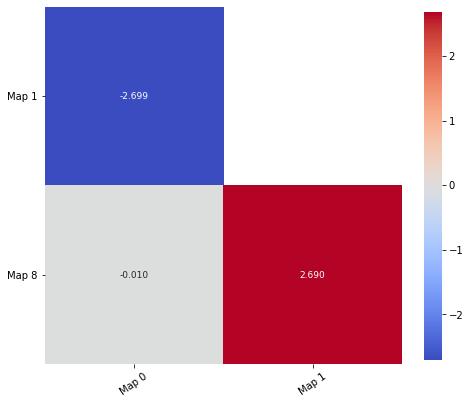

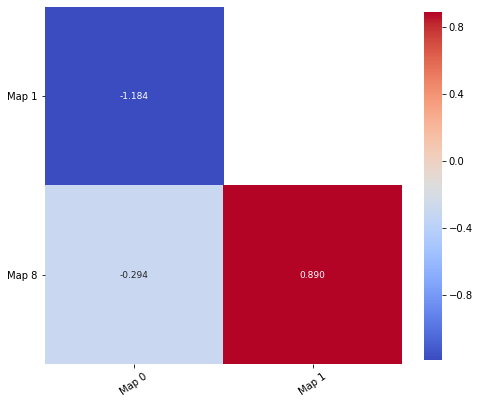

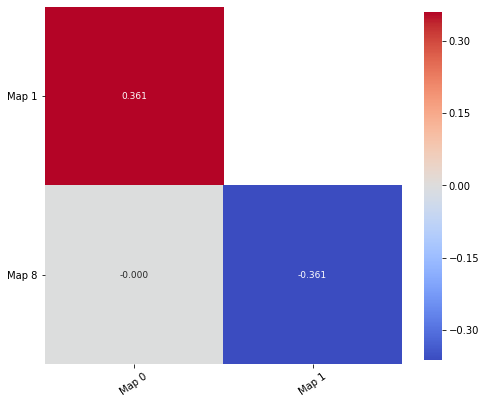

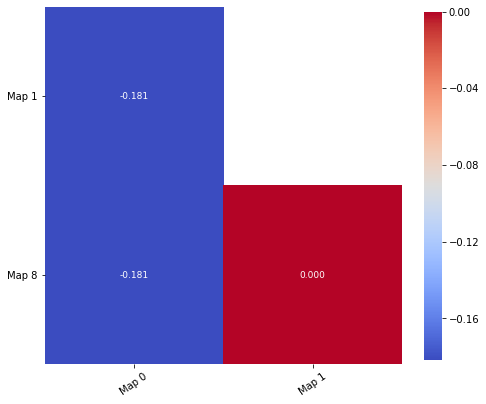

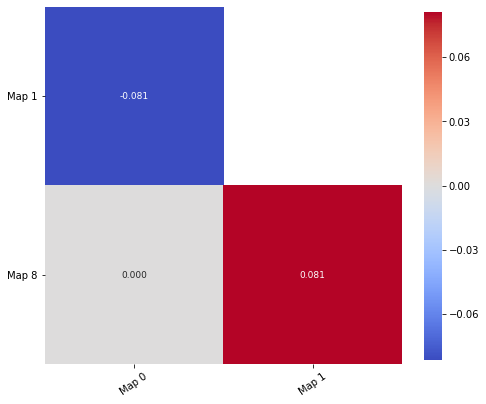

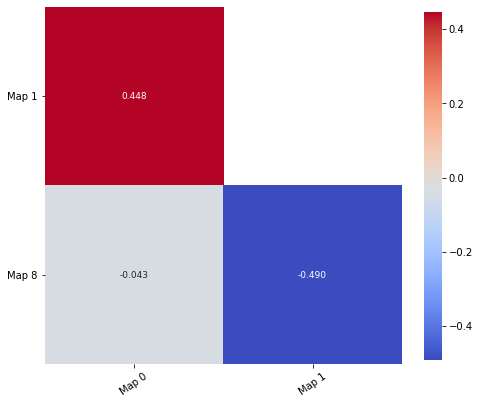

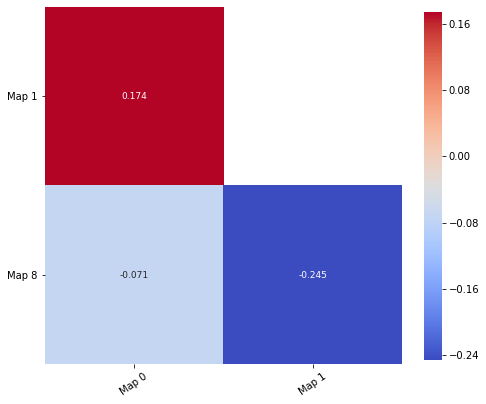

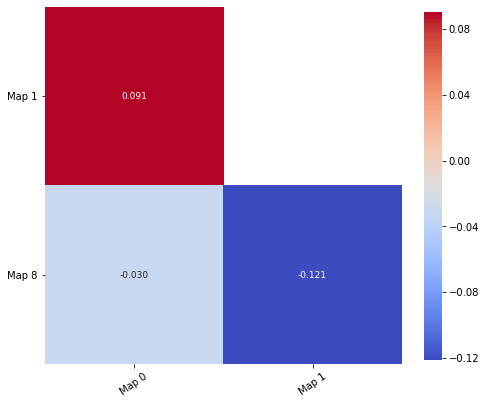

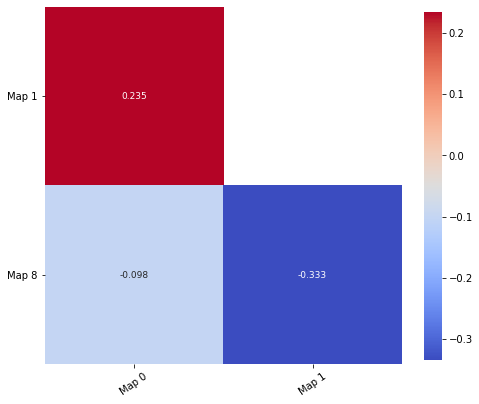

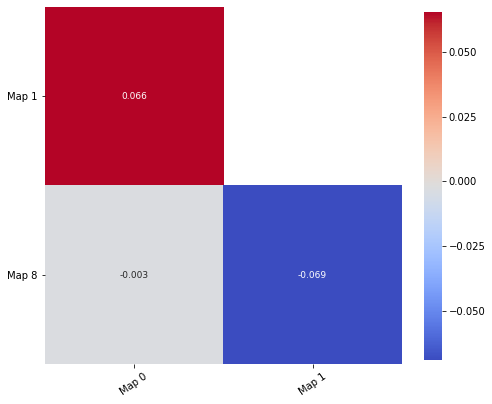

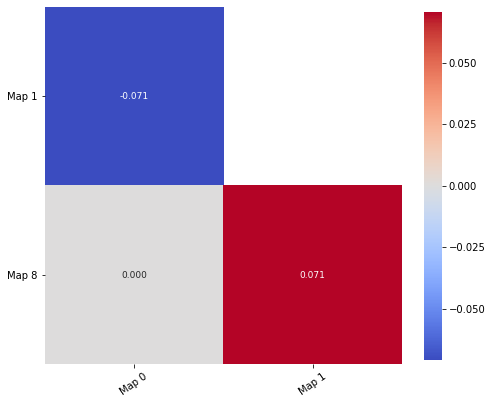

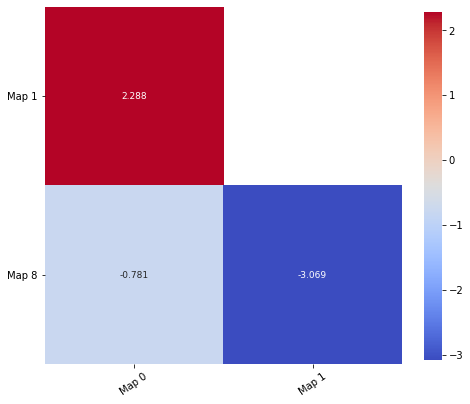

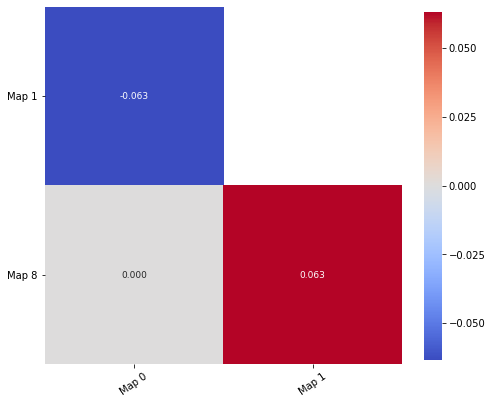

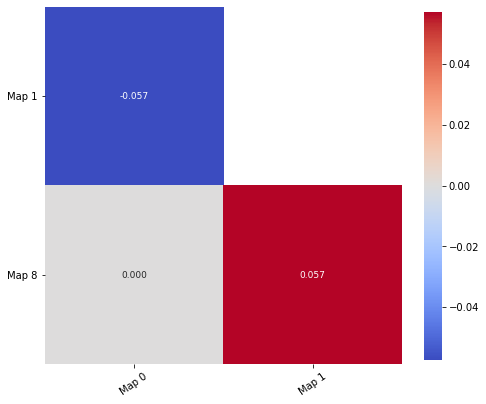

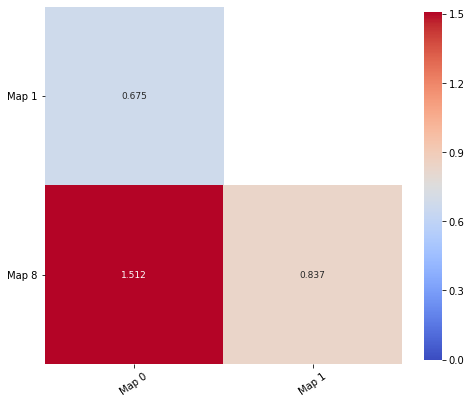

In [109]:
# Store all categories for analysis
cats12 = list(df12.columns)
#Create heatmaps for all overall accuracy categories and save to disk
for i in range(len(cats12)):
    process_cat(df12, cats12[i], 'qd22', qd22_maps, cats12)